# Generating figures for benchmark
Comparison between Symphony, Seurat, and scArches

June 23, 2021

In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R') # imports
    source('../R/utils.R') # useful functions
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

In [2]:
celltype.colors = c('alpha'="#ed2bb1",
                    'beta'="#239eb3",
                    'gamma'="#d1bfec",
                    'delta'= "#FF6347",
                    'stellate'="#11e38c",
                    'immune'="#812050",
                    'ductal'="#b2d27a",
                    'endothelial'="#4e2da6",
                    'acinar'="#f6bb86",
                    'schwann'="#115d52",
                    'epsilon'="#a1def0")

gray = '#BEBEBE'

celltype.gray = c('alpha'=gray,
                    'beta'=gray,
                    'gamma'=gray,
                    'delta'=gray,
                    'stellate'=gray,
                    'immune'=gray,
                    'ductal'=gray,
                    'endothelial'=gray,
                    'acinar'=gray,
                    'schwann'=gray,
                    'epsilon'=gray,
                    'mast'=gray)

dataset.colors = c('celseq' = '#8796ad',
                   'celseq2' = '#add7d9',
                   'smartseq' = '#bbd1a5',
                   'c1' = '#d9cfad')

querydonor.colors = c('human1' = '#b9dbf0',
                      'human2' = '#77a1ba',
                      'human3' = '#6c7ca8',
                      'human4' = '#364261',
                      'mouse1' = '#e68c8c',
                      'mouse2' = '#b35757')

querydonor.colors2 = c('human 1' = '#b9dbf0',
                      'human 2' = '#77a1ba',
                      'human 3' = '#6c7ca8',
                      'human 4' = '#364261',
                      'mouse 1' = '#e68c8c',
                      'mouse 2' = '#b35757')

batchnn.colors = c('celseq' = '#8796ad',
                   'celseq2' = '#add7d9',
                   'smartseq' = '#bbd1a5',
                   'c1' = '#d9cfad',
                   'human1' = '#b9dbf0',
                      'human2' = '#77a1ba',
                      'human3' = '#6c7ca8',
                      'human4' = '#364261',
                      'mouse1' = '#e68c8c',
                      'mouse2' = '#b35757')

tf.colors = c('TRUE' = '#8FBC8F',
              'FALSE' = '#ed4f1a')

## Query PCA

Run a standard PCA pipeline on the query itself.

In [3]:
## Read in query expression and metadata
human_exp_norm = readRDS('../data/Fig4_pancreas_multi/baron_human_exp.rds')
mouse_exp_norm = readRDS('../data/Fig4_pancreas_multi/baron_mouse_biomart_homologene_exp.rds')
metadata_combined = readRDS('../data/Fig4_pancreas_multi/metadata_combined.rds')

## To map the human and mouse simultaneously, combine the two sparse matrices
combined_filled <- t(plyr::rbind.fill.matrix(t(mouse_exp_norm), t(human_exp_norm)))
combined_filled[is.na(combined_filled)] = 0 # fill in any missing genes with 0
colnames(combined_filled) = c(colnames(mouse_exp_norm), colnames(human_exp_norm))
dim(combined_filled)

[1] 26000 10455

Plot to show cell types expected in each query donor

In [4]:
t = table(metadata_combined$species_donor, metadata_combined$cell_type) %>% as.data.frame()
t %>% head(3)

Var1    Var2   Freq
1 human 1 acinar 110 
2 human 2 acinar   3 
3 human 3 acinar 843

In [5]:
table(metadata_combined$species_donor, metadata_combined$cell_type)

         
          acinar alpha beta delta ductal endothelial epsilon gamma immune
  human 1    110   236  872   214    120         130      13    70     24
  human 2      3   676  371   125    301          23       2    86     28
  human 3    843  1130  787   161    376          92       2    36     23
  human 4      2   284  495   101    280           7       1    63     12
  mouse 1      0     9  343    85    236          72       0    14     27
  mouse 2      0   182  551   133     39          67       0    27     34
         
          schwann stellate
  human 1       5      143
  human 2       6      103
  human 3       1      154
  human 4       1       57
  mouse 1       3       33
  mouse 2       3       28

png 
  2

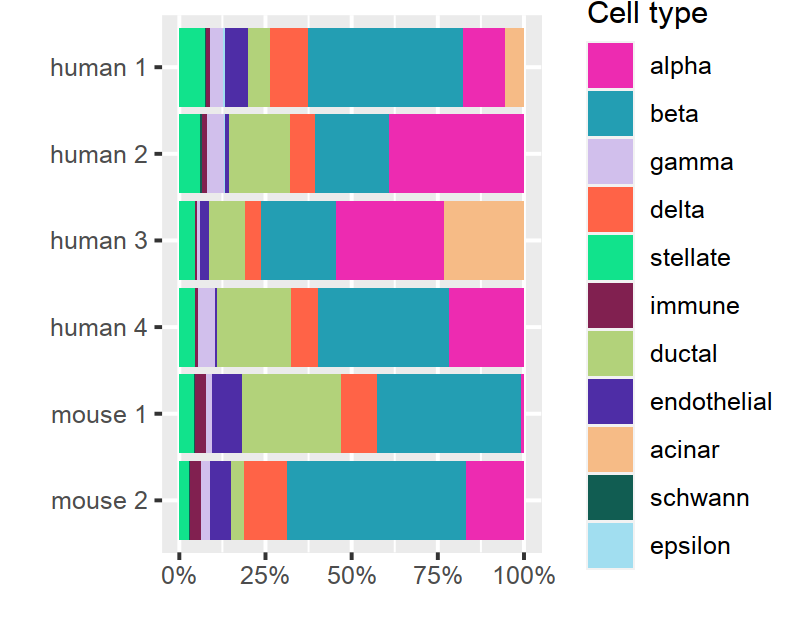

In [6]:
fig.size(3.2, 4)
p = ggplot(t, aes(x = reorder(Var1, desc(Var1)), y = Freq, fill = Var2)) + 
    geom_bar(position = "fill",stat = "identity") +
    xlab('') + ylab('') +
    scale_fill_manual(values = celltype.colors) +
    scale_y_continuous(labels = scales::percent_format()) + coord_flip() +
    theme(legend.position="right") + labs(fill = 'Cell type') 
pdf('figures/query_props.pdf', height=3.2, width=4, useDingbats=FALSE)
print(p)
dev.off()
p

In [7]:
# Subset by variable genes
combined_filled = Matrix(combined_filled)
var_genes = vargenes_vst(combined_filled, topn = 3000)
combined_exp = combined_filled[var_genes, ]

vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(combined_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(combined_exp, vargenes_means_sds$mean)

# Scale data
exp_scaled <- singlecellmethods::scaleDataWithStats(combined_exp, vargenes_means_sds$mean, 
                                                    vargenes_means_sds$stddev, 1)

# Run SVD, save loadings
s = irlba(exp_scaled, nv = 20)
Z_pca = diag(s$d) %*% t(s$v) # [pcs by cells]

# UMAP
set.seed(0)
umap <- uwot::umap(t(Z_pca), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
            metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
            min_dist = .3, n_threads = 4, ret_model = TRUE)

png 
  2

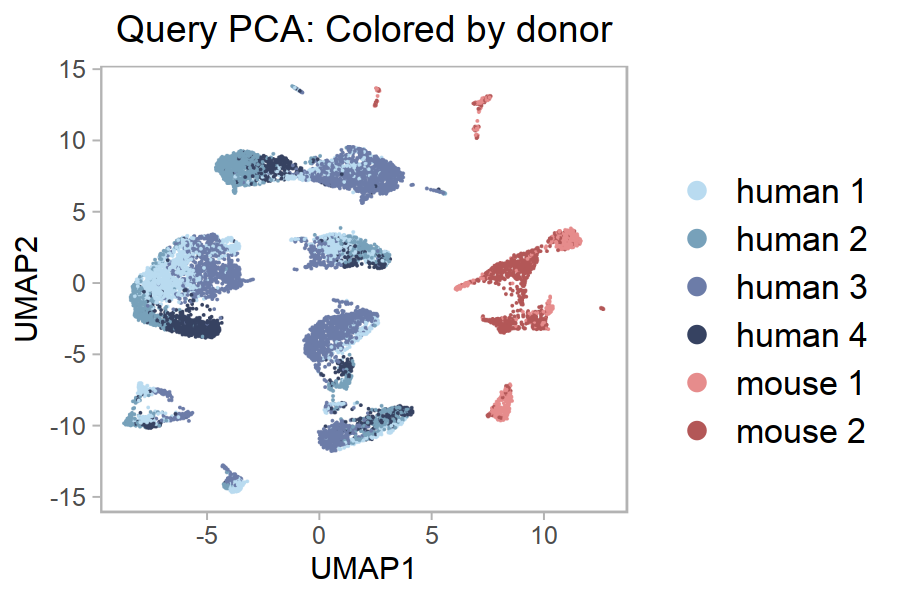

In [8]:
fig.size(3, 4.5)

# Add UMAP coordinates
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
umap_labels = cbind(metadata_combined, umap$embedding)

# Plot UMAP visualization
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = species_donor)) +
    geom_point_rast(size = 0.4, stroke = 0.2, shape = 16) +
    theme_light() +
    labs(title = 'Query PCA: Colored by donor', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="right", legend.text = element_text(size=12)) +
    scale_color_manual(values = querydonor.colors2) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 1)) +
    theme(strip.text.x = element_text(size = 12)) + theme(panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())
pdf('figures/query_pca_bydonor.pdf', width = 4.5, height = 3, useDingbats = FALSE)
print(p1)
dev.off()
p1

png 
  2

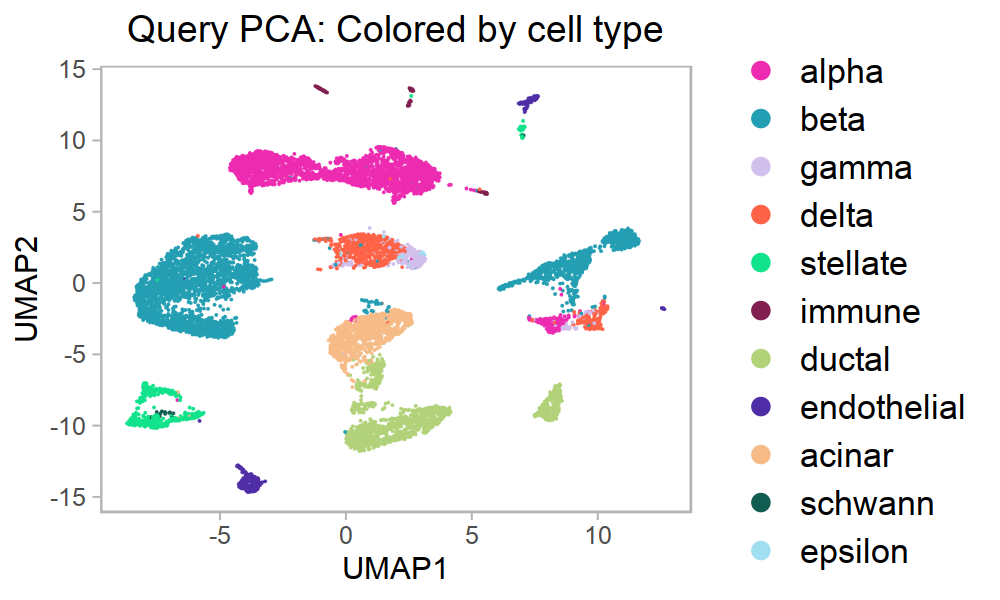

In [9]:
pdf('figures/query_pca_bycelltype.pdf', width = 6, height = 4.5, useDingbats = FALSE)
fig.size(3, 5)

# Add UMAP coordinates
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
umap_labels = cbind(metadata_combined, umap$embedding)

# Plot UMAP visualization
p2 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.4, stroke = 0.2, shape = 16) +
    theme_light() +
    labs(title = 'Query PCA: Colored by cell type', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="right", legend.text = element_text(size=12)) +
    scale_color_manual(values = celltype.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    theme(strip.text.x = element_text(size = 14)) + theme(panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())
print(p2)
dev.off()
p2

png 
  2

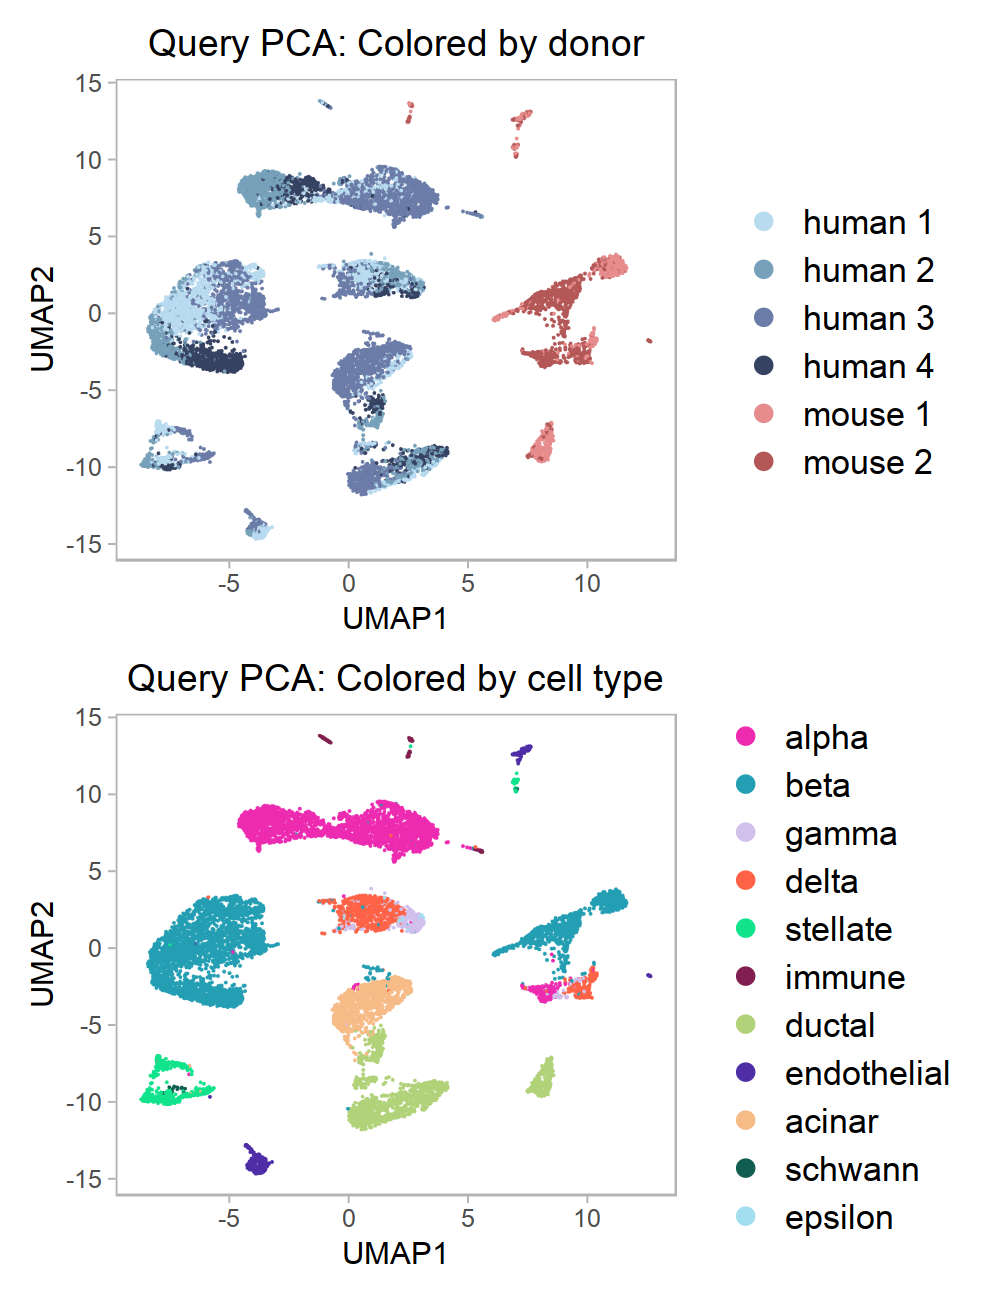

In [10]:
fig.size(6.5, 5)
pdf('figures/query_pca_sidebyside.pdf', width = 5, height = 6.5, useDingbats = FALSE)
library(patchwork)
print(p1 / p2)

dev.off()
p1 / p2

In [11]:
lisis = compute_lisi(t(Z_pca), metadata_combined, c('species', 'species_donor', 'cell_type'))
lisis %>% head(3)

species species_donor cell_type
mouse1_lib1.final_cell_0001 1       1.928775      1.00000  
mouse1_lib1.final_cell_0002 1       1.061781      1.00000  
mouse1_lib1.final_cell_0003 1       1.786691      1.00279

In [12]:
n = nrow(lisis)
mu = mean(lisis$species_donor)
me = qt(.975, n - 1)* sd(lisis$species_donor)/sqrt(n)
print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))

[1] "1.45 (1.44, 1.46)"


In [13]:
lisis_mouse = lisis[which(metadata_combined$species == 'mouse'), ]
mean(lisis_mouse$species_donor)

[1] 1.347106

In [14]:
lisis_human = lisis[which(metadata_combined$species == 'human'), ]
mean(lisis_human$species_donor)

[1] 1.472306

## Functions to calculate results metrics and make graphs for each tool

### Calculate results
Takes in an embedding and calculates LISI, predicts query cell types using 5-NN, and runs de novo UMAP

Expects rows of allZ to match all_meta

In [15]:
calculateResults = function(results_dir, method, allZ, all_meta) {
    all_meta$cell_type = as.character(all_meta$cell_type)
    
    message('Predict query cell types')
    all_meta$pred_cell_type_5nn = NA
    idx_ref = which(all_meta$ref_query == 'reference')
    idx_q = which(all_meta$ref_query == 'query')
    Zr = allZ[idx_ref, ]
    Zq = allZ[-idx_ref, ]
    meta_r = all_meta[idx_ref, ]
    meta_q = all_meta[-idx_ref, ]
    
    set.seed(0) # some randomness to 5-NN
    class_res = class::knn(Zr, Zq, meta_r$cell_type, k = 5, prob = TRUE)
    all_meta$pred_cell_type_5nn[idx_q] = as.character(class_res)
    all_meta$pred_cell_type_5nn_prob[idx_q] = attributes(class_res)$prob
    
    message('Calculate LISI')
    lisis = compute_lisi(allZ, all_meta, c('donor', 'cell_type', 'dataset', 'ref_query'))
    colnames(lisis) = c('donor_lisi', 'cell_type_lisi', 'dataset_lisi', 'ref_query_lisi')
    all_meta = cbind(all_meta, lisis)
    
    message('Run de novo UMAP on query and reference cells')
    set.seed(0)
    umap <- uwot::umap(
            allZ, n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
            metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
            min_dist = .3, n_threads = 4, ret_model = TRUE)
    colnames(umap$embedding) = c('UMAP1', 'UMAP2')
    all_meta = cbind(all_meta, umap$embedding)    
    return(all_meta)
}

### Calculate query lisi
Calculates LISI scores within the query

In [16]:
calculateQueryLISI = function(allZ, all_meta) {
    message('Calculate query LISI')
    set.seed(0)
    
    idx_q = which(all_meta$ref_query == 'query')
    queryZ = allZ[idx_q, ]
    querymeta = all_meta[idx_q, ]
    
    lisis = compute_lisi(queryZ, querymeta, c('donor', 'species', 'cell_type'))
    colnames(lisis) = c('query_cells_donor_lisi', 'query_cells_species_lisi', 'query_cells_cell_type_lisi')
    querymeta = cbind(querymeta, lisis)
    return(querymeta)
}

### Draw Mapping Graphs
Make nice UMAP plots for each method

Expects having previously run calculateResults (for updated metadata, above)

In [17]:
drawMappingGraphs = function(results_dir, method, allZ, all_meta) {
    nbins = 10 # number of bins
    bandwidth = 1.5 # bandwidth for kernel estimation
    umap_labels = all_meta
    
    # Make cell type labels
    labels.cent = umap_labels[which(umap_labels$ref_query == 'reference'), ] %>% 
    dplyr::group_by(cell_type) %>%
    dplyr::select(UMAP1, UMAP2) %>% 
    summarize_all(median)
    
    message('Plot the reference density')
    fig.size(5, 5)
    pdf(paste0(results_dir, '/', method, '_ref_density.pdf'), height=5, width=5, useDingbats=FALSE)

    ref_umap_labels = umap_labels[which(umap_labels$ref_query == 'reference'), ]

    a = ref_umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell_type), 
                    contour_var = "ndensity", bins = nbins, h = bandwidth) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_fill_manual(values = celltype.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), color = 'black', size = 6)
    print(a)
    dev.off()
    
    a_legend = ref_umap_labels %>%
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell_type), 
                    contour_var = "ndensity", bins = nbins, h=bandwidth) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_fill_manual(values = celltype.colors) +
        theme(legend.position="right") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), color = 'black', size = 6) +
        guides(colour = guide_legend(override.aes = list(size = 5)))
    
    message('Plot the reference points')
    fig.size(5, 5)
    pdf(paste0(results_dir, '/', method, '_ref_points.pdf'), height=5, width=5, useDingbats=FALSE)

    ref_umap_labels = umap_labels[which(umap_labels$ref_query == 'reference'), ]

    b = ref_umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(aes(color = dataset), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = dataset.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), color = 'black', size = 6)
    print(b)
    dev.off()
    
    b_legend = ref_umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(aes(color = dataset), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = dataset.colors) +
        theme(legend.position="bottom") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), color = 'black', size = 6) +
        guides(colour = guide_legend(override.aes = list(size = 5)))

    message('Plot the mapping of query cells on reference density')
    fig.size(5, 5)
    pdf(paste0(results_dir, '/', method, '_mapping_celltype.pdf'), height=5, width=5, useDingbats=FALSE)

    ref_umap_labels = umap_labels[which(umap_labels$ref_query == 'reference'), ]

    c = ref_umap_labels %>%
        #sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell_type), 
                        contour_var = "ndensity", bins = nbins, h=bandwidth) +
        geom_point_rast(data = umap_labels[which(umap_labels$ref_query == 'query'), ], 
                   aes(x = UMAP1, y = UMAP2, color = cell_type), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + #Symphony mapping
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_fill_manual(values = celltype.gray) +
        scale_color_manual(values = celltype.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=0)) + xlab('') + ylab('')
    print(c)
    dev.off()
    
    message('Plot the prediction of query cells')
    ## Correct vs. incorrect prediction
    meta_q = umap_labels[which(umap_labels$ref_query == 'query'), ]
    meta_q$predict_correct = (as.character(meta_q$pred_cell_type_5nn) == as.character(meta_q$cell_type)) 
    predhuman = meta_q$predict_correct[which(meta_q$species == 'human')]
    predmouse = meta_q$predict_correct[which(meta_q$species == 'mouse')]
    
    fig.size(5, 5)

    # Human
    pdf(paste0(results_dir, '/', method, '_query_predict_human.pdf'), height=5, width=5, useDingbats=FALSE)
    p1 = ref_umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell_type), 
                    contour_var = "ndensity", bins = nbins, h=bandwidth) +
        geom_point_rast(data = umap_labels[which(umap_labels$ref_query == 'query' & umap_labels$species == 'human'), ], 
               aes(x = UMAP1, y = UMAP2, color = predhuman), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_fill_manual(values = celltype.gray) +
        scale_color_manual(values = tf.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=0)) + xlab('') + ylab('')
    print(p1)
    dev.off()

    # Mouse
    pdf(paste0(results_dir, '/', method, '_query_predict_mouse.pdf'), height=5, width=5, useDingbats=FALSE)
    p2 = ref_umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell_type), 
                    contour_var = "ndensity", bins = nbins, h=bandwidth) +
        geom_point_rast(data = umap_labels[which(umap_labels$ref_query == 'query' & umap_labels$species == 'mouse'), ], 
               aes(x = UMAP1, y = UMAP2, color = predmouse), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_fill_manual(values = celltype.gray) +
        scale_color_manual(values = tf.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=0)) + xlab('') + ylab('')
    print(p2)
    dev.off()
    
    message('Plot the mapping of query cells on reference density, colored by query donor')
    fig.size(5, 5)
    pdf(paste0(results_dir, '/', method, '_mapping_querydonor.pdf'), height=5, width=5, useDingbats=FALSE)

    ref_umap_labels = umap_labels[which(umap_labels$ref_query == 'reference'), ]
    query_umap_labels = umap_labels[which(umap_labels$ref_query == 'query'), ] %>% sample_frac(1L) # %>% # permute rows randomly

    d = ref_umap_labels %>%
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        stat_density2d(geom='polygon', aes(alpha = ..level.., fill = cell_type), 
                        contour_var = "ndensity", bins = nbins, h=bandwidth) +
        geom_point_rast(data = query_umap_labels, 
                   aes(x = UMAP1, y = UMAP2, color = donor), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_fill_manual(values = celltype.gray) +
        scale_color_manual(values = querydonor.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=0)) + xlab('') + ylab('')
    print(d)
    dev.off()
    
    d_legend = ref_umap_labels %>%
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(data = query_umap_labels, 
                   aes(x = UMAP1, y = UMAP2, color = donor), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = querydonor.colors) +
        theme(legend.position="bottom") +
        theme(axis.text=element_text(size=0)) + xlab('') + ylab('') +
        guides(colour = guide_legend(override.aes = list(size = 5)))
    
    ## Get legends
    a_leg <- get_legend(a_legend)
    as_ggplot(a_leg)
    ggsave(paste0(results_dir, '/', 'legend_cell_type_legend.pdf'), height=5, width=5, useDingbats=FALSE)
    
    b_leg <- get_legend(b_legend)
    as_ggplot(b_leg)
    ggsave(paste0(results_dir, '/', 'legend_ref_donor_legend.pdf'), height=5, width=5, useDingbats=FALSE)
    
    d_leg <- get_legend(d_legend)
    as_ggplot(d_leg)
    ggsave(paste0(results_dir, '/', 'legend_query_donor_legend.pdf'), height=5, width=5, useDingbats=FALSE)

    return( list(a , b , c , d , p1 , p2) )
}

### Draw de novo Graphs

Makes nice plots for the de novo integration version for each method.

In [18]:
## Expects having previously run calculateResults (for updated metadata)
drawDeNovoGraphs = function(results_dir, method, allZ, all_meta) {
    
    nbins = 10 # number of bins
    bandwidth = 1.5 #bandwidth for kernel estimation
    umap_labels = all_meta
    
    # Make cell type labels
    labels.cent = umap_labels %>% 
    dplyr::group_by(cell_type) %>%
    dplyr::select(UMAP1, UMAP2) %>% 
    summarize_all(median)
    
    message('Plot the points, color by batch')
    fig.size(5, 5)
    pdf(paste0(results_dir, '/', method, '_denovo_points_colorbybatch.pdf'), height=5, width=5, useDingbats=FALSE)

    b = umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(aes(color = batch), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = batchnn.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('')
    print(b)
    dev.off()
    
    b_legend = umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(aes(color = batch), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = batchnn.colors) +
        theme(legend.position="bottom") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        guides(colour = guide_legend(override.aes = list(size = 5)))

    message('Plot the points, color by cell type')
    fig.size(5, 5)
    pdf(paste0(results_dir, '/', method, '_denovo_points_colorbycelltype.pdf'), height=5, width=5, useDingbats=FALSE)

    c = umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(aes(color = cell_type), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') +
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = celltype.colors) +
        theme(legend.position="none") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), color = 'black', size = 6)
    print(c)
    dev.off()
    
    c_legend = umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(aes(color = cell_type), size = 0.4, stroke = 0.2, shape = 16) +
        theme_minimal() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = celltype.colors) +
        theme(legend.position="right") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), color = 'black', size = 6)
    
    ## Get legends
    b_leg <- get_legend(b_legend)
    as_ggplot(b_leg)
    ggsave(paste0(results_dir, '/', 'legend_batch_legend.pdf'), height=5, width=5, useDingbats=FALSE)
    
    c_leg <- get_legend(c_legend)
    as_ggplot(c_leg)
    ggsave(paste0(results_dir, '/', 'legend_celltypes_denovo_legend.pdf'), height=5, width=5, useDingbats=FALSE)

    return( list(b , c) )
}

# Make plots for reference mapping embeddings

## Process Symphony

In [19]:
method = 'Symphony'
results_dir = 'results'

all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = readRDS('Symphony/Symphony_mapping_embedding.rds')

In [20]:
symphony_results_meta = calculateResults(results_dir, method, allZ, all_meta)
saveRDS(symphony_results_meta, file.path(results_dir, 'Symphony_mapping_meta_results.rds'))

Predict query cell types

Calculate LISI

Run de novo UMAP on query and reference cells



In [21]:
symphony_query_lisis = calculateQueryLISI(allZ, all_meta)
saveRDS(symphony_query_lisis, file.path(results_dir, 'Symphony_query_lisis.rds'))

Calculate query LISI



In [22]:
lisis = compute_lisi(allZ[which(all_meta$ref_query == 'query'),], 
                     all_meta[which(all_meta$ref_query == 'query'),], 
                     c('species', 'donor', 'cell_type'))

## Compute query lisis (not separated by human/mouse)
n = nrow(lisis)
mu = mean(lisis$donor)
me = qt(.975, n - 1)* sd(lisis$donor)/sqrt(n)
print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))

lisis$species_label = all_meta$species[which(all_meta$ref_query == 'query')]

[1] "2.72 (2.7, 2.73)"


In [23]:
lisis_mouse = lisis[which(lisis$species_label == 'mouse'),]
mean(lisis_mouse$donor)

[1] 2.912742

In [24]:
lisis_human = lisis[which(lisis$species_label == 'human'),]
mean(lisis_human$donor)

[1] 2.671775

In [25]:
p = drawMappingGraphs(file.path('figures'), method, allZ, symphony_results_meta)

Adding missing grouping variables: `cell_type`

Plot the reference density

Plot the reference points

Plot the mapping of query cells on reference density

Plot the prediction of query cells

Plot the mapping of query cells on reference density, colored by query donor



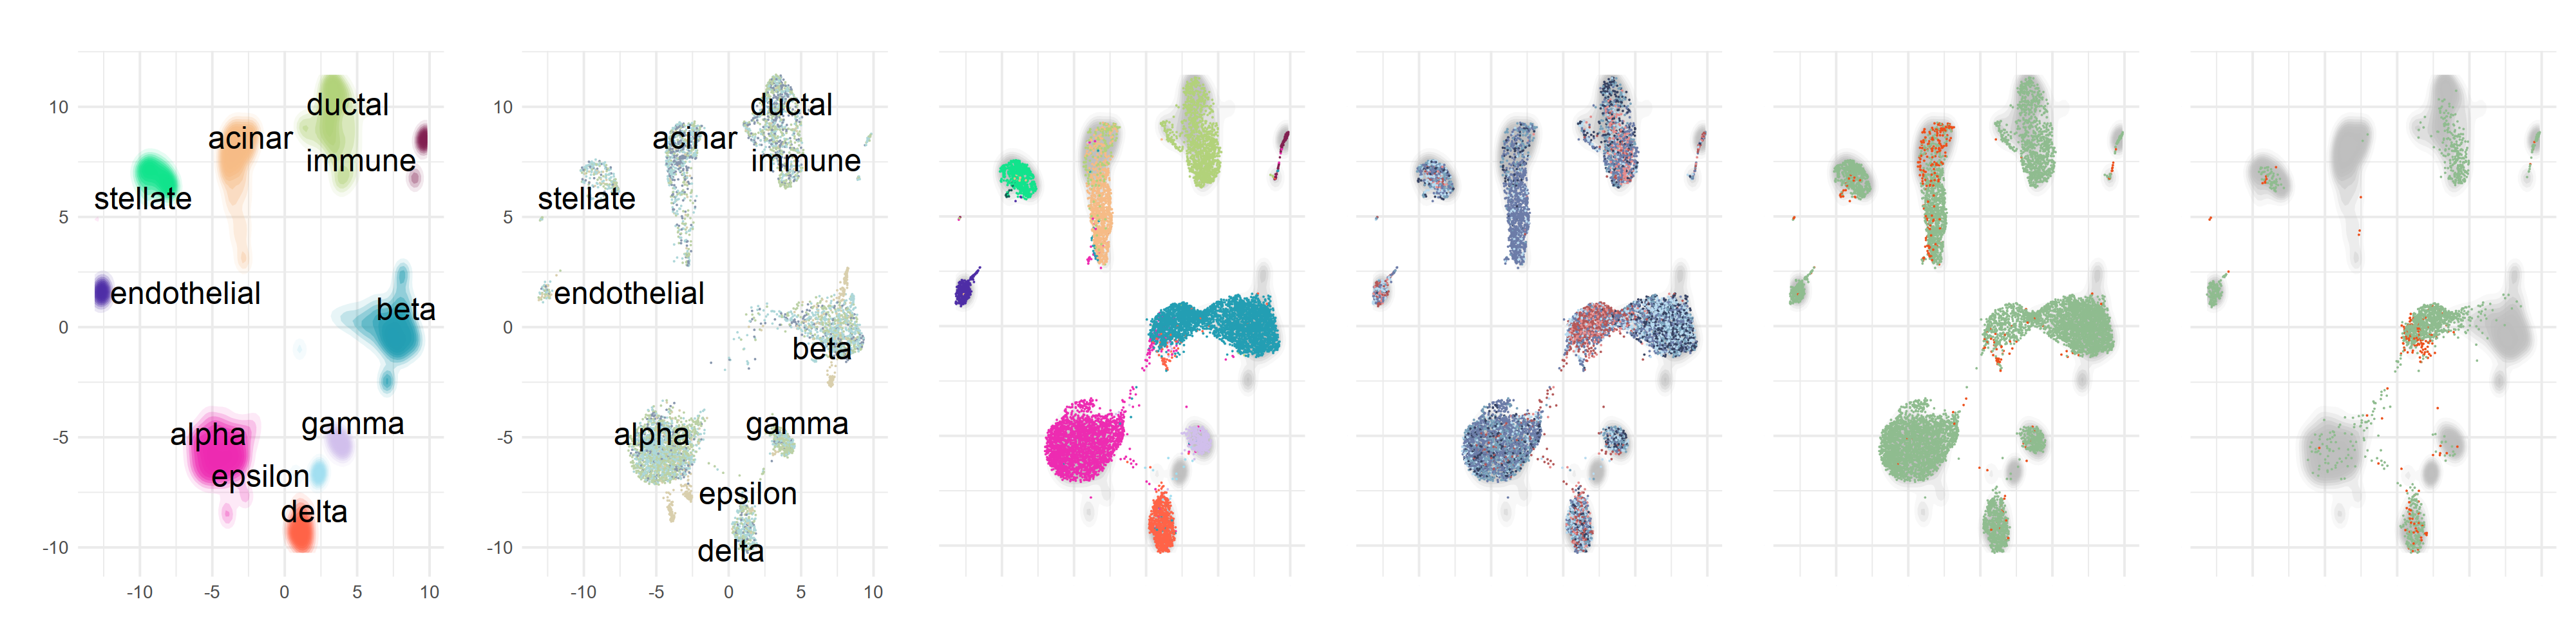

In [26]:
fig.size(5, 20)
print(p[[1]] | p[[2]] | p[[3]] | p[[4]] | p[[5]] | p[[6]])

### Are the two immune populations different?

In [27]:
umap_labels = symphony_results_meta

Adding missing grouping variables: `cell_type`



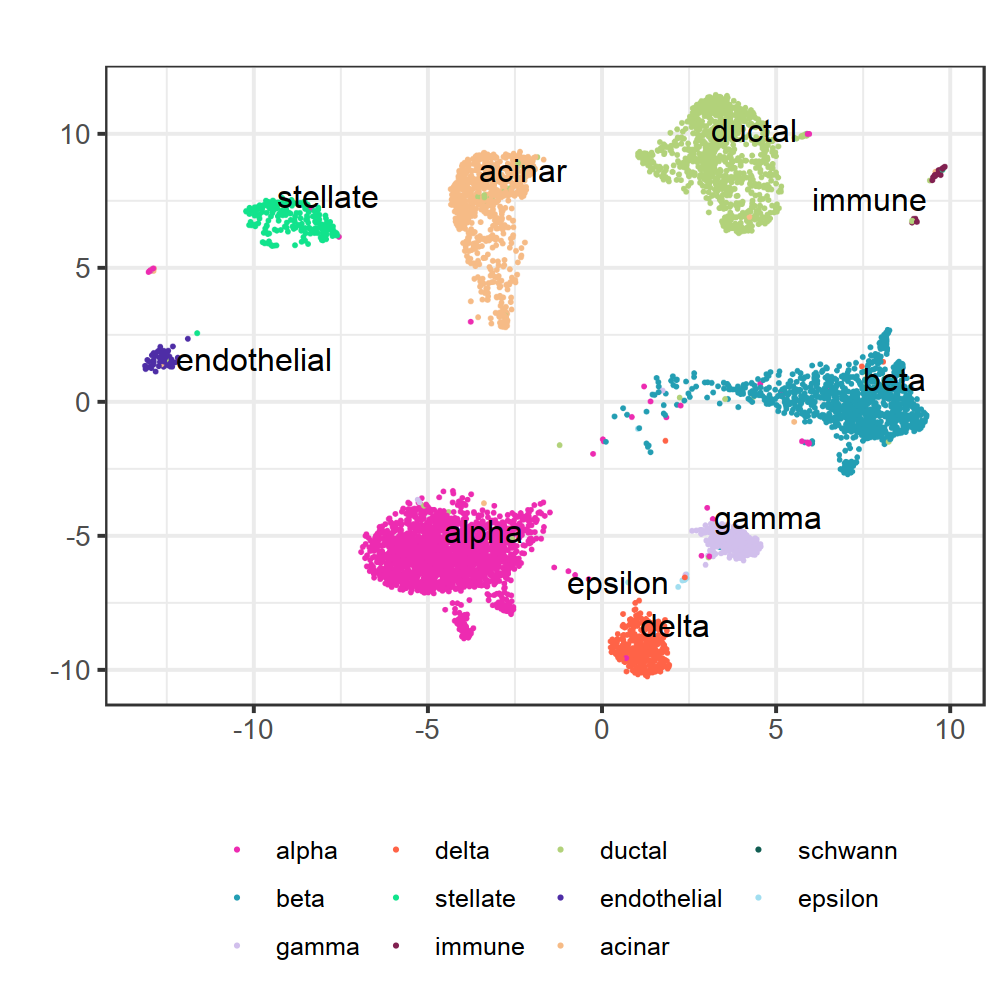

In [28]:
fig.size(5, 5)
#pdf(paste0(results_dir, '/', method, '_ref_density.pdf'), height=5, width=5, useDingbats=FALSE)

ref_umap_labels = umap_labels[which(umap_labels$ref_query == 'reference'), ]

# Make cell type labels
labels.cent = ref_umap_labels %>% 
    dplyr::group_by(cell_type) %>%
    dplyr::select(UMAP1, UMAP2) %>% 
    summarize_all(median)

a = ref_umap_labels %>%
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = UMAP1, y = UMAP2)) +
        geom_point_rast(size = 0.1, aes(col = cell_type)) +
        theme_bw() +
        labs(title = '', color = '', fill = '') + 
        theme(plot.title = element_text(hjust = 0.5)) + 
        scale_color_manual(values = celltype.colors) +
        theme(legend.position="bottom") +
        theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
        ggrepel::geom_text_repel(data = labels.cent, aes(label = cell_type), 
                                 color = 'black', size = 4)
print(a)
#dev.off()

In [29]:
immune_idx_1 = which(ref_umap_labels$cell_type == 'immune' & ref_umap_labels$UMAP2 > 7.5)
immune_idx_2 = which(ref_umap_labels$cell_type == 'immune' & ref_umap_labels$UMAP2 <= 7.5)

ref_umap_labels$immune = 'non-immune'
ref_umap_labels$immune[immune_idx_1] = 'immune_1'
ref_umap_labels$immune[immune_idx_2] = 'immune_2'

In [30]:
table(ref_umap_labels$immune)


  immune_1   immune_2 non-immune 
        20          7       5860 

In [31]:
library(presto)
ref_exp = readRDS('../data/Fig4_pancreas_multi/reference_four_exp.rds')
markers = presto::wilcoxauc(ref_exp, ref_umap_labels$immune)
top_markers(markers, n=10, auc_min=0, pval_max=1, padj_max=1,
                        pct_in_min=0, pct_out_max=100)

rank immune_1 immune_2 non-immune
1   1   ITGB2    RAC2     EPCAM     
2   2   TYROBP   GATA2    PERP      
3   3   IFI30    CPA3     DSP       
4   4   HCK      CD22     TUSC3     
5   5   LAPTM5   TPSAB1   DSTN      
6   6   TNFRSF1B HPGDS    ATP1B1    
7   7   HCLS1    RHOH     TPD52     
8   8   GRB2     CD37     NCKAP1    
9   9   CD74     SASH3    CTTN      
10 10   WIPF1    RGS10    DDR1

In [32]:
lineage_markers = c('CD3D', # T
                    'MS4A1', # B cells
                    'CD14', 'CD16', 'LYZ', # Macrophage
                    'KIT') # Mast cells
m = markers %>% subset(feature %in% lineage_markers & auc >= 0.62)
m

feature group    avgExpr   logFC     statistic auc       pval        
2178  CD14    immune_1 0.8906322 0.7628579  90209.5  0.7687873 1.262186e-08
7319  LYZ     immune_1 3.3979756 2.7848067 108780.5  0.9270539 2.876471e-12
22113 KIT     immune_2 2.9112932 2.8951355  41118.0  0.9989796 1.511501e-71
      padj         pct_in pct_out  
2178  3.598987e-07  65    22.294188
7319  1.191603e-10  95    52.565195
22113 6.452851e-69 100     2.108844

Immune 1 (20 cells) is likely macrophage (LYZ+), immune 2 (7 cells) is likely mast cells (KIT+); however, given the small number of cells in each cluster we decided to just aggregate them together under an "immune" label.

## Process scArches

In [33]:
method = 'scArches'

In [34]:
all_scArches = read.csv('scArches/trvae_pancreasmapindrop_X.csv', header = FALSE)
meta_scArches = read.csv('scArches/trvae_pancreasmapindrop_meta.csv')
rownames(all_scArches) = meta_scArches$cell_id

In [35]:
# Sort all such that the cell order matches
all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = all_scArches[order(match(rownames(all_scArches), rownames(all_meta))), ]
dim(allZ)
allZ %>% tail(2)

saveRDS(allZ, file.path(results_dir, 'scArches_mapping_allZ.rds'))

[1] 16342    10

V1        V2         V3        V4        
human4_lib3.final_cell_0700-1 0.5096602  0.0601889 -1.268381 -0.3281353
human4_lib3.final_cell_0701-1 0.4233649 -1.0613168 -1.262566 -0.3932912
                              V5         V6         V7        V8       
human4_lib3.final_cell_0700-1 -0.1137672 -0.5499725 -1.704831 0.7180742
human4_lib3.final_cell_0701-1  0.3378433  0.4024375 -2.012212 1.3567555
                              V9         V10      
human4_lib3.final_cell_0700-1  0.3191188 1.3593569
human4_lib3.final_cell_0701-1 -1.8563862 0.7976595

In [36]:
scArches_results_meta = calculateResults(results_dir, method, allZ, all_meta)
saveRDS(scArches_results_meta, file.path(results_dir, 'scArches_mapping_meta_results.rds'))

Predict query cell types

Calculate LISI

Run de novo UMAP on query and reference cells



In [37]:
scArches_query_lisis = calculateQueryLISI(allZ, all_meta)
saveRDS(scArches_query_lisis, file.path(results_dir, 'scArches_query_lisis.rds'))

Calculate query LISI



In [38]:
p = drawMappingGraphs(file.path('figures'), method, allZ, scArches_results_meta)

Adding missing grouping variables: `cell_type`

Plot the reference density

Plot the reference points

Plot the mapping of query cells on reference density

Plot the prediction of query cells

Plot the mapping of query cells on reference density, colored by query donor



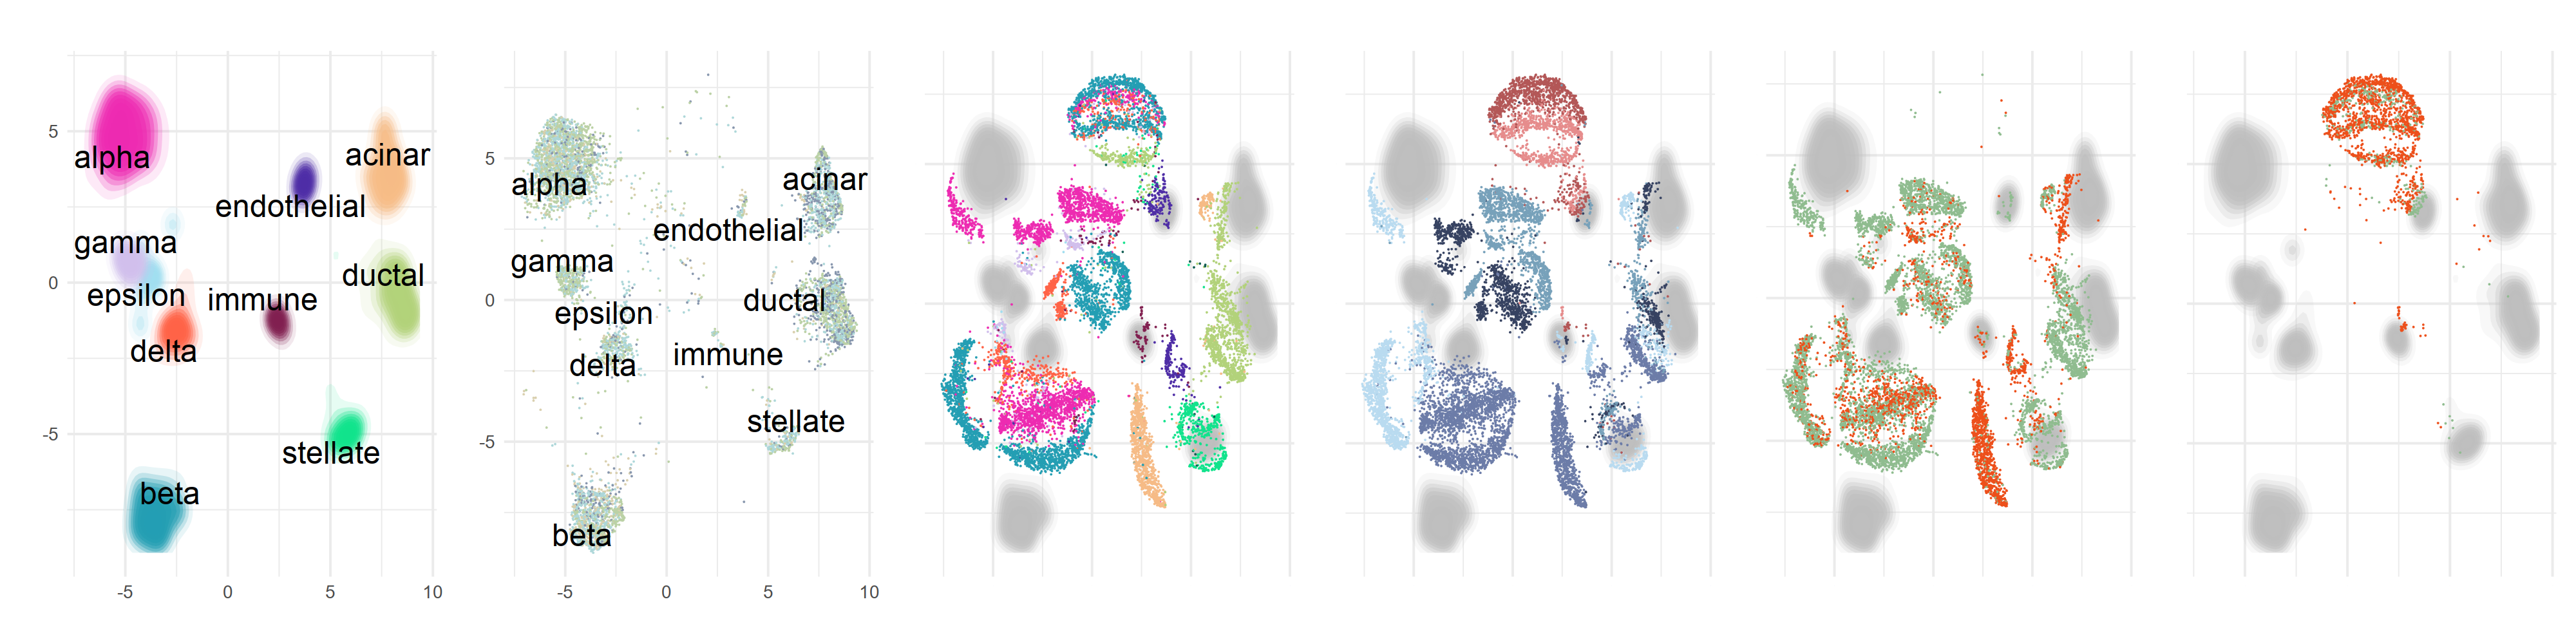

In [39]:
fig.size(5, 20)
print(p[[1]] | p[[2]] | p[[3]] | p[[4]] | p[[5]] | p[[6]])

## Process Seurat

In [40]:
method = 'Seurat'

In [41]:
all_Seurat = readRDS('Seurat/Seurat_mapping_embedding_ref_human_mouse.rds')
all_Seurat$dataset = NULL

In [42]:
# Sort all such that the cell order matches
all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = all_Seurat[order(match(rownames(all_Seurat), rownames(all_meta))), ]
dim(allZ)
allZ %>% tail(2)

saveRDS(allZ, file.path(results_dir, 'Seurat_mapping_allZ.rds'))

[1] 16342    20

PC_1       PC_2      PC_3       PC_4        
human4_lib3.final_cell_0700   7.952997 -1.137581  0.0989012 -0.220875127
human4_lib3.final_cell_0701 -12.989841  5.210868 13.5077951  0.001574271
                            PC_5      PC_6      PC_7       PC_8      
human4_lib3.final_cell_0700 -7.534824 0.9242006 -2.9105951 -0.1065149
human4_lib3.final_cell_0701 -2.248044 1.1193897 -0.8068258  1.9969084
                            PC_9       PC_10     PC_11     PC_12     PC_13     
human4_lib3.final_cell_0700 -0.3342758  1.667149  1.681424 -1.787668 -2.7548580
human4_lib3.final_cell_0701  1.8678323 -2.644716 -1.097636  1.341338 -0.2030257
                            PC_14     PC_15      PC_16      PC_17    PC_18     
human4_lib3.final_cell_0700 -2.479146 1.56913550 -1.5968136 3.671855 -0.4151881
human4_lib3.final_cell_0701 -1.738760 0.05356834 -0.6769325 1.710393 -1.1270688
                            PC_19     PC_20     
human4_lib3.final_cell_0700 4.2625875  0.5098708
human4_lib3.final_cell_0701 0.5344672 -1.7904715

In [43]:
seurat_results_meta = calculateResults(results_dir, method, allZ, all_meta)
saveRDS(seurat_results_meta, file.path(results_dir, 'Seurat_mapping_meta_results.rds'))

Predict query cell types

Calculate LISI

Run de novo UMAP on query and reference cells



In [44]:
seurat_query_lisis = calculateQueryLISI(allZ, all_meta)
saveRDS(seurat_query_lisis, file.path(results_dir, 'Seurat_query_lisis.rds'))

Calculate query LISI



In [45]:
p = drawMappingGraphs(file.path('figures'), method, allZ, seurat_results_meta)

Adding missing grouping variables: `cell_type`

Plot the reference density

Plot the reference points

Plot the mapping of query cells on reference density

Plot the prediction of query cells

Plot the mapping of query cells on reference density, colored by query donor



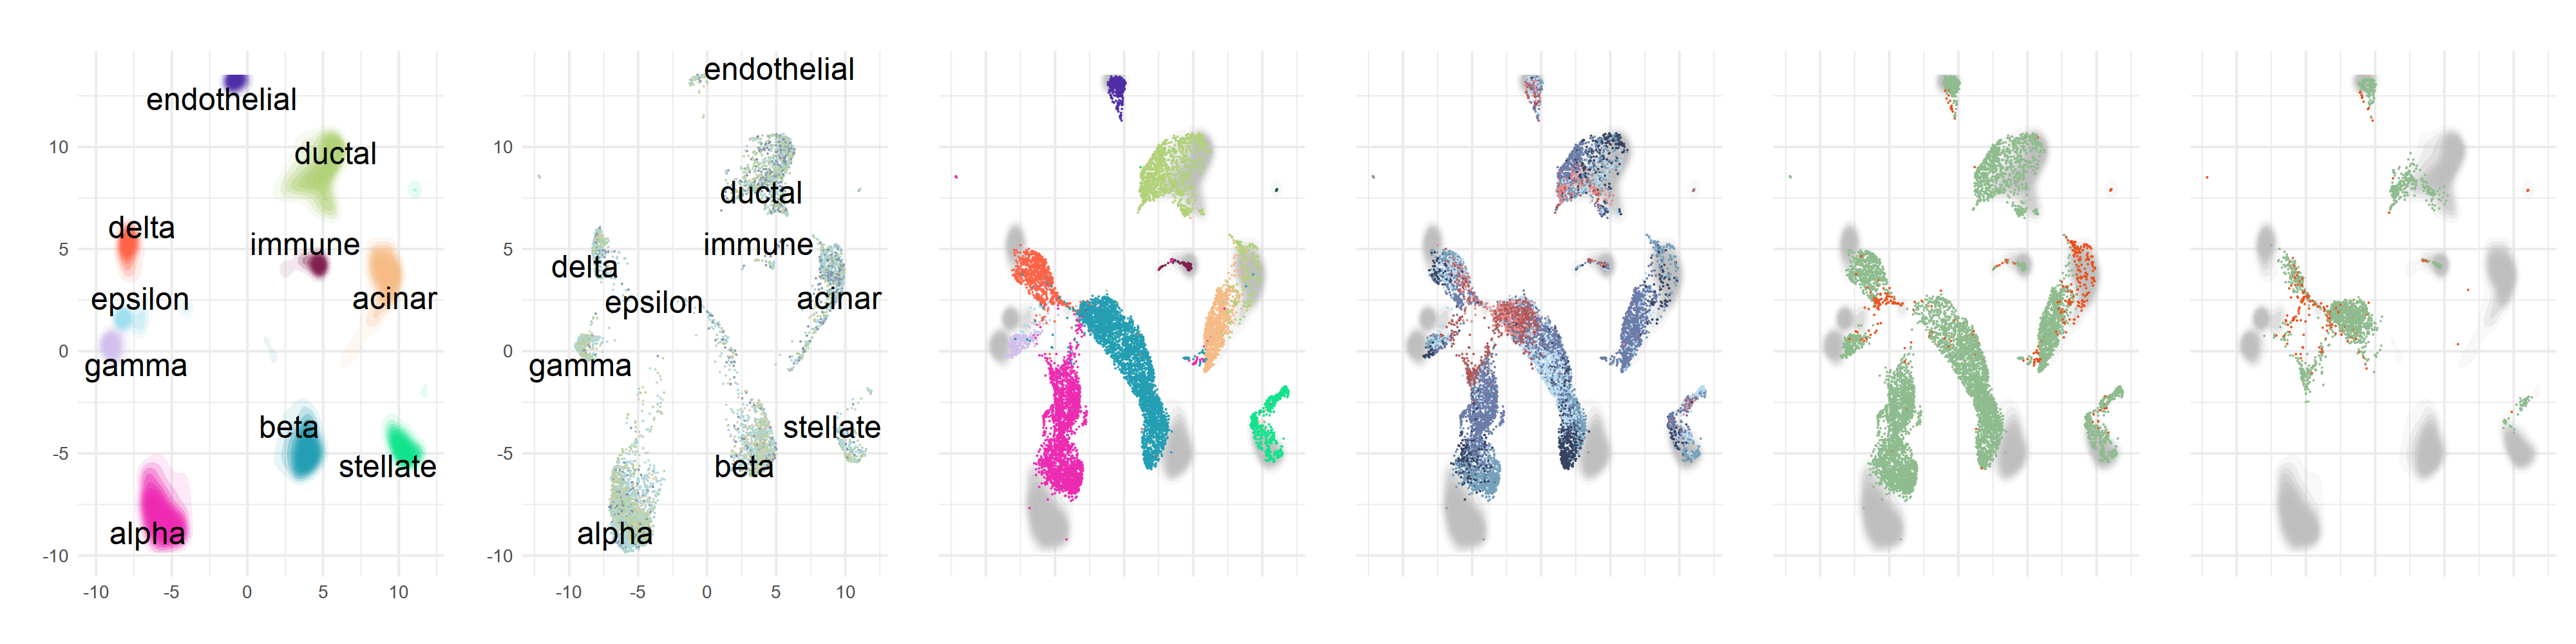

In [46]:
fig.size(5, 20)
print(p[[1]] | p[[2]] | p[[3]] | p[[4]] | p[[5]] | p[[6]])

## Plot ref/query LISI comparison

In [47]:
results_dir = 'results'

In [48]:
Symphony_res = readRDS(file.path(results_dir, 'Symphony_mapping_meta_results.rds'))
Symphony_res$Method = 'Symphony'

Seurat_res = readRDS(file.path(results_dir, 'Seurat_mapping_meta_results.rds'))
Seurat_res$Method = 'Seurat'

scArches_res = readRDS(file.path(results_dir, 'scArches_mapping_meta_results.rds'))
scArches_res$Method = 'scArches'

res_agg = rbind(Symphony_res, Seurat_res, scArches_res)
res_agg_query = res_agg[which(res_agg$ref_query == 'query'), ]

png 
  2

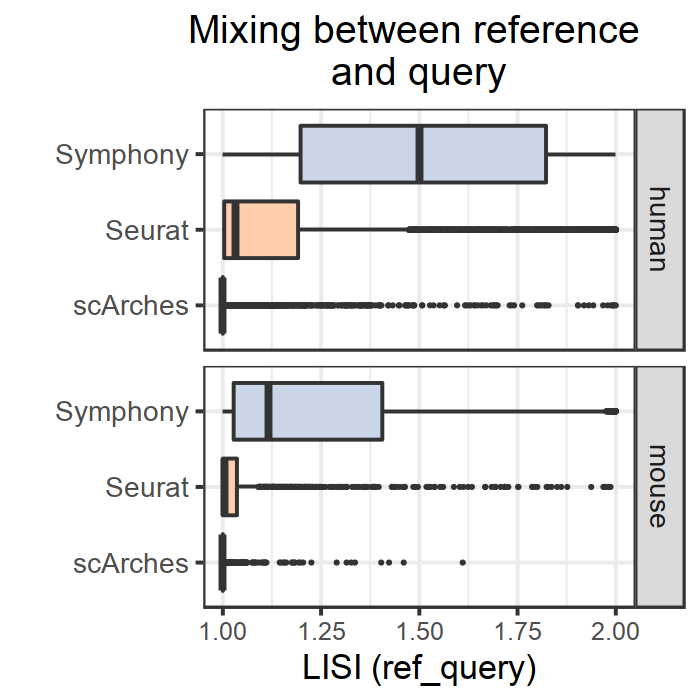

In [49]:
fig.size(3.5, 3.5)
pdf(paste0('figures/lisi_refquery.pdf'), height=3.5, width=3.5, useDingbats=FALSE)

library(ggridges)
l = ggplot(res_agg_query) +
    geom_boxplot(aes(x=ref_query_lisi, y=Method, fill=Method), outlier.size = 0.1) +
    #geom_density_ridges(aes(x=ref_query_lisi, y=Method, fill=Method, height =..ndensity..), scale = 1, alpha = 0.8, size = 0.4,
    #                    quantile_lines=TRUE,
    #                    quantile_fun=function(x,...)mean(x)) +
    theme_bw() +
    ylab('') + xlab('LISI (ref_query)') + ggtitle('Mixing between reference \nand query') +
    theme(axis.text.y = element_text(hjust = 1, size=10),
        strip.text.y = element_text(size=10),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12),
        legend.position = "none") +
    scale_fill_brewer(palette = 'Pastel2') +
    facet_wrap(~species, nrow = 2, strip.position = 'right')
                      
print(l)
dev.off()
l

### print ref/query LISI stats

In [50]:
head(res_agg_query, 3)
table(res_agg_query$Method)

cell_id                     dataset nGene donor 
mouse1_lib1.final_cell_0001 mouse1_lib1.final_cell_0001 inDrop  3205  mouse1
mouse1_lib1.final_cell_0002 mouse1_lib1.final_cell_0002 inDrop  3829  mouse1
mouse1_lib1.final_cell_0003 mouse1_lib1.final_cell_0003 inDrop  2582  mouse1
                            cell_type ref_query species batch 
mouse1_lib1.final_cell_0001 beta      query     mouse   mouse1
mouse1_lib1.final_cell_0002 ductal    query     mouse   mouse1
mouse1_lib1.final_cell_0003 delta     query     mouse   mouse1
                            pred_cell_type_5nn pred_cell_type_5nn_prob
mouse1_lib1.final_cell_0001 beta               1                      
mouse1_lib1.final_cell_0002 ductal             1                      
mouse1_lib1.final_cell_0003 delta              1                      
                            donor_lisi cell_type_lisi dataset_lisi
mouse1_lib1.final_cell_0001 1.721521   1.000000       1.032302    
mouse1_lib1.final_cell_0002 3.346295   1.000000       1.364788    
mouse1_lib1.final_cell_0003 7.448560   1.006678       2.171872    
                            ref_query_lisi UMAP1     UMAP2     Method  
mouse1_lib1.final_cell_0001 1.032302       2.7016821  0.958558 Symphony
mouse1_lib1.final_cell_0002 1.342623       4.3815575  6.540542 Symphony
mouse1_lib1.final_cell_0003 1.999021       0.7387692 -9.841139 Symphony


scArches   Seurat Symphony 
   10455    10455    10455 

In [51]:
# 95% CI, alpha = .05
for (tool in c('scArches', 'Seurat', 'Symphony')) {
    for (species in c('human', 'mouse')) {
        res = res_agg_query[which(res_agg_query$Method == tool & res_agg_query$species == species), ]
                print(paste0('Mean ref_query LISI and 95% CI for ', tool, ' and ', species, ':'))
        n = nrow(res)
        mu = mean(res$ref_query_lisi)
        me = qt(.975, n - 1)* sd(res$ref_query_lisi)/sqrt(n)
        print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
    }
}

[1] "Mean ref_query LISI and 95% CI for scArches and human:"
[1] "1.02 (1.01, 1.02)"
[1] "Mean ref_query LISI and 95% CI for scArches and mouse:"
[1] "1 (1, 1.01)"
[1] "Mean ref_query LISI and 95% CI for Seurat and human:"
[1] "1.17 (1.16, 1.18)"
[1] "Mean ref_query LISI and 95% CI for Seurat and mouse:"
[1] "1.05 (1.04, 1.05)"
[1] "Mean ref_query LISI and 95% CI for Symphony and human:"
[1] "1.51 (1.5, 1.51)"
[1] "Mean ref_query LISI and 95% CI for Symphony and mouse:"
[1] "1.26 (1.24, 1.27)"


## Plot query LISI comparison

In [52]:
symphony_query_lisis = readRDS(file.path(results_dir, 'Symphony_query_lisis.rds'))
seurat_query_lisis = readRDS(file.path(results_dir, 'Seurat_query_lisis.rds'))
scArches_query_lisis = readRDS(file.path(results_dir, 'scArches_query_lisis.rds'))

symphony_query_lisis$Method = 'Symphony'
seurat_query_lisis$Method = 'Seurat'
scArches_query_lisis$Method = 'scArches'

res_agg = rbind(symphony_query_lisis, seurat_query_lisis, scArches_query_lisis)
dim(res_agg)

[1] 31365    12

png 
  2

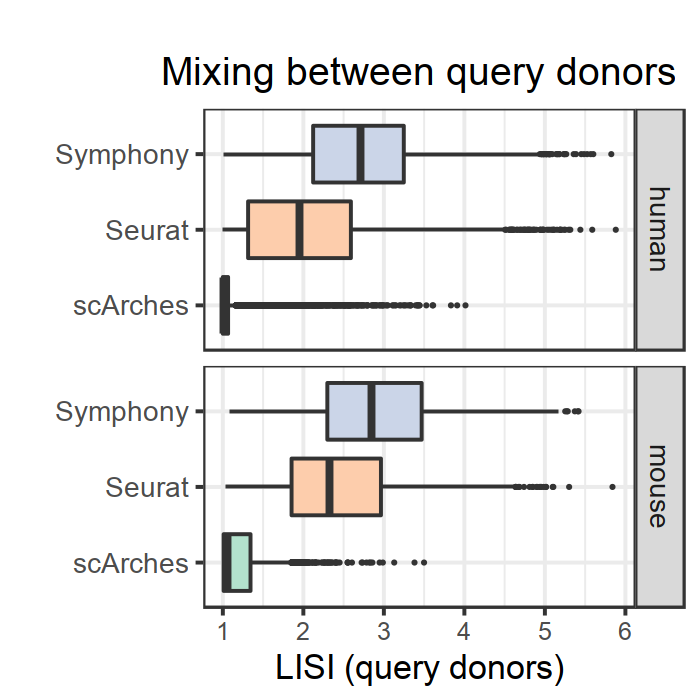

In [53]:
fig.size(3.5, 3.5)
pdf(paste0('figures/lisi_querydonor.pdf'), height=3.5, width=3.5, useDingbats=FALSE)

l = ggplot(res_agg) + # fill=name allow to automatically dedicate a color for each group
        geom_boxplot(aes(x=query_cells_donor_lisi, y=Method, fill=Method), outlier.size = 0.1) +
  #geom_density_ridges(aes(x=query_cells_donor_lisi, y=Method, fill=Method, height =..ndensity..), scale = 1, alpha = 0.8, size = 0.4,
  #                    quantile_lines=TRUE,
  #                    quantile_fun=function(x,...)mean(x)) +
  theme_bw() +
  ylab('') + xlab('LISI (query donors)') + ggtitle('\nMixing between query donors') +
  theme(axis.text.y = element_text(hjust = 1, size=10),
        strip.text.y = element_text(size=10),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12),
        legend.position = "none") +
  scale_fill_brewer(palette = 'Pastel2') +
  facet_wrap(~species, nrow = 2, strip.position = 'right')

print(l)
dev.off()
l

### print query LISI stats

In [54]:
head(res_agg)

cell_id                     dataset nGene donor 
mouse1_lib1.final_cell_0001 mouse1_lib1.final_cell_0001 inDrop  3205  mouse1
mouse1_lib1.final_cell_0002 mouse1_lib1.final_cell_0002 inDrop  3829  mouse1
mouse1_lib1.final_cell_0003 mouse1_lib1.final_cell_0003 inDrop  2582  mouse1
mouse1_lib1.final_cell_0004 mouse1_lib1.final_cell_0004 inDrop  3041  mouse1
mouse1_lib1.final_cell_0005 mouse1_lib1.final_cell_0005 inDrop  2548  mouse1
mouse1_lib1.final_cell_0006 mouse1_lib1.final_cell_0006 inDrop  2828  mouse1
                            cell_type ref_query species batch 
mouse1_lib1.final_cell_0001 beta      query     mouse   mouse1
mouse1_lib1.final_cell_0002 ductal    query     mouse   mouse1
mouse1_lib1.final_cell_0003 delta     query     mouse   mouse1
mouse1_lib1.final_cell_0004 schwann   query     mouse   mouse1
mouse1_lib1.final_cell_0005 delta     query     mouse   mouse1
mouse1_lib1.final_cell_0006 beta      query     mouse   mouse1
                            query_cells_donor_lisi query_cells_species_lisi
mouse1_lib1.final_cell_0001 1.684670               1.304774                
mouse1_lib1.final_cell_0002 2.546953               1.990418                
mouse1_lib1.final_cell_0003 3.177033               1.344947                
mouse1_lib1.final_cell_0004 4.412060               1.540107                
mouse1_lib1.final_cell_0005 3.838632               1.784432                
mouse1_lib1.final_cell_0006 2.548976               1.283524                
                            query_cells_cell_type_lisi Method  
mouse1_lib1.final_cell_0001 1.000000                   Symphony
mouse1_lib1.final_cell_0002 1.000000                   Symphony
mouse1_lib1.final_cell_0003 1.016848                   Symphony
mouse1_lib1.final_cell_0004 1.326154                   Symphony
mouse1_lib1.final_cell_0005 1.015793                   Symphony
mouse1_lib1.final_cell_0006 1.171780                   Symphony

In [55]:
# 95% CI, alpha = .05
for (tool in c('Symphony','Seurat', 'scArches')) {
    for (species in c('human', 'mouse')){
        res = res_agg[which(res_agg$Method == tool & res_agg$species == species), ]
        print(paste0('Mean query_donor LISI and 95% CI for ', tool, ' and ', species, ':'))
        n = nrow(res)
        mu = mean(res$query_cells_donor_lisi)
        me = qt(.975, n - 1)* sd(res$query_cells_donor_lisi)/sqrt(n)
        print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
    }
}

[1] "Mean query_donor LISI and 95% CI for Symphony and human:"
[1] "2.67 (2.65, 2.69)"
[1] "Mean query_donor LISI and 95% CI for Symphony and mouse:"
[1] "2.91 (2.88, 2.95)"
[1] "Mean query_donor LISI and 95% CI for Seurat and human:"
[1] "2.04 (2.03, 2.06)"
[1] "Mean query_donor LISI and 95% CI for Seurat and mouse:"
[1] "2.46 (2.42, 2.5)"
[1] "Mean query_donor LISI and 95% CI for scArches and human:"
[1] "1.12 (1.11, 1.12)"
[1] "Mean query_donor LISI and 95% CI for scArches and mouse:"
[1] "1.24 (1.22, 1.26)"


# Plot classification accuracy

## Symphony

In [56]:
## Symphony classification
Symphony_res_query = Symphony_res[which(Symphony_res$ref_query == 'query' & 
                                        Symphony_res$cell_type != 'schwann'), ]
Symphony_f1_by_species = list()
for (species in unique(Symphony_res_query$species)) {
    print(paste('Species:', species))
    species_res = Symphony_res_query[which(Symphony_res_query$species == species),]
    res = symphony:::evaluate(species_res$cell_type, species_res$pred_cell_type_5nn)
    print(res)
    write.csv(res$Conf, paste0(results_dir, '/', 'Symphony_', species, '_conf.csv'))
    Symphony_f1_by_species[[species]] = res$F1
}

[1] "Species: mouse"
$Conf
             pred_lab
true_lab      acinar alpha beta delta ductal endothelial gamma immune stellate
  alpha            0   123   56     9      0           0     3      0        0
  beta             0     7  861    25      0           0     1      0        0
  delta            0     3   29   185      0           0     1      0        0
  ductal           2     0    2     0    270           0     0      0        1
  endothelial      0     0    0     0      0         139     0      0        0
  gamma            0     4   18     5      0           0    14      0        0
  immune           1     0    1     0      1           0     0     58        0
  stellate         0     0    0     0      0           1     0      1       59

$MedF1
[1] 0.9459878

$F1
      alpha        beta       delta      ductal endothelial       gamma 
  0.7500000   0.9253090   0.8371041   0.9890110   0.9964158   0.4666667 
     immune    stellate 
  0.9666667   0.9752066 

$Acc
[1] 0.90904

In [57]:
Symphony_f1_by_species

$mouse
      alpha        beta       delta      ductal endothelial       gamma 
  0.7500000   0.9253090   0.8371041   0.9890110   0.9964158   0.4666667 
     immune    stellate 
  0.9666667   0.9752066 

$human
     acinar       alpha        beta       delta      ductal endothelial 
  0.8928571   0.9894374   0.9819909   0.9506803   0.9036813   0.9880000 
    epsilon       gamma      immune    stellate 
  0.6153846   0.9685039   0.9479769   0.9827214

## Seurat (using 5-NN)

In [58]:
## Seurat classification using 5-NN

Seurat_res_query = Seurat_res[which(Seurat_res$ref_query == 'query' & 
                                    Seurat_res$cell_type != 'schwann'), ]
Seurat_f1_by_species = list()
for (species in unique(Seurat_res_query$species)) {
    print(paste('Species:', species))
    species_res = Seurat_res_query[which(Seurat_res_query$species == species),]
    res = symphony:::evaluate(species_res$cell_type, species_res$pred_cell_type_5nn)
    write.csv(res$Conf, paste0(results_dir, '/', 'Seurat_', species, '_conf.csv'))
    print(res)
    Seurat_f1_by_species[[species]] = res$F1
}

[1] "Species: mouse"
$Conf
             pred_lab
true_lab      acinar alpha beta delta ductal endothelial epsilon gamma immune
  alpha            0   161   17     6      0           0       3     4      0
  beta             0    28  850    15      0           0       1     0      0
  delta            0    12   38   156      0           0       6     6      0
  ductal           2     1    2     0    270           0       0     0      0
  endothelial      0     5    2     0      2         129       0     0      0
  gamma            0     5   11     2      0           0       3    20      0
  immune           1     0    1     0      5           0       0     0     54
  stellate         0     0    0     0      0           1       0     0      1
             pred_lab
true_lab      stellate
  alpha              0
  beta               0
  delta              0
  ductal             0
  endothelial        1
  gamma              0
  immune             0
  stellate          59

$MedF1
[1] 0.933836

In [59]:
Seurat_f1_by_species

$mouse
      alpha        beta       delta      ductal endothelial       gamma 
  0.7990074   0.9366391   0.7858942   0.9782609   0.9591078   0.5633803 
     immune    stellate 
  0.9310345   0.9752066 

$human
     acinar       alpha        beta       delta      ductal endothelial 
  0.8980170   0.9869295   0.9748724   0.9264448   0.8965863   0.9631148 
    epsilon       gamma      immune    stellate 
  0.3636364   0.9625247   0.9411765   0.9780702

## Seurat (using TransferData)

In [60]:
Seurat_mouse_obj = readRDS('Seurat/Seurat_query_mouse_obj.rds')
Seurat_human_obj = readRDS('Seurat/Seurat_query_human_obj.rds')

In [61]:
Seurat_mouse_obj@meta.data$species = 'mouse'
Seurat_human_obj@meta.data$species = 'human'
Seurat_combined_meta = rbind(Seurat_mouse_obj@meta.data, Seurat_human_obj@meta.data)
Seurat_combined_meta %>% head(3)

Seurat_combined_meta = Seurat_combined_meta[which(Seurat_combined_meta$cell_type != 'schwann'), ]

orig.ident nCount_RNA nFeature_RNA donor dataset
mouse1_lib1.final_cell_0001 mouse1     239.8725   185          1     inDrop 
mouse1_lib1.final_cell_0002 mouse1     354.1381   253          1     inDrop 
mouse1_lib1.final_cell_0003 mouse1     278.9404   204          1     inDrop 
                            cell_type cell_subtype predicted.cell_type.score
mouse1_lib1.final_cell_0001 beta      beta         0.8411656                
mouse1_lib1.final_cell_0002 ductal    ductal       1.0000000                
mouse1_lib1.final_cell_0003 delta     delta        0.8011475                
                            predicted.cell_type species
mouse1_lib1.final_cell_0001 beta                mouse  
mouse1_lib1.final_cell_0002 ductal              mouse  
mouse1_lib1.final_cell_0003 delta               mouse

In [62]:
table(Seurat_combined_meta$species, Seurat_combined_meta$cell_type)

       
        acinar alpha beta delta ductal endothelial epsilon gamma immune
  human    958  2326 2525   601   1077         252      18   255     87
  mouse      0   191  894   218    275         139       0    41     61
       
        stellate
  human      457
  mouse       61

In [63]:
Seurat_f1_by_species_TD = list()
for (species in unique(Seurat_combined_meta$species)) {
    print(paste('Species:', species))
    species_res = Seurat_combined_meta[which(Seurat_combined_meta$species == species), ]
    res = symphony:::evaluate(species_res$cell_type, species_res$predicted.cell_type)
    write.csv(res$Conf, paste0(results_dir, '/', 'Seurat_', species, '_conf_TD.csv'))
    print(res)
    Seurat_f1_by_species_TD[[species]] = res$F1
}

[1] "Species: mouse"
$Conf
             pred_lab
true_lab      acinar alpha beta delta ductal endothelial epsilon gamma immune
  alpha            0   150   31     8      0           0       0     2      0
  beta             0    18  856    20      0           0       0     0      0
  delta            0     6   36   167      0           0       1     8      0
  ductal           1     0    2     0    272           0       0     0      0
  endothelial      0     4    2     0      1         129       0     0      0
  gamma            0     6   13     6      0           0       0    16      0
  immune           1     0    2     0      0           0       0     0     58
  stellate         0     0    0     0      0           1       0     0      0
             pred_lab
true_lab      stellate
  alpha              0
  beta               0
  delta              0
  ductal             0
  endothelial        3
  gamma              0
  immune             0
  stellate          60

$MedF1
[1] 0.945784

## scArches

In [64]:
## scArches classification

scArches_res_query = scArches_res[which(scArches_res$ref_query == 'query' & 
                                        scArches_res$cell_type != 'schwann'), ]
scArches_f1_by_species = list()
for (species in unique(scArches_res_query$species)) {
    print(paste('Species:', species))
    species_res = scArches_res_query[which(scArches_res_query$species == species),]
    res = symphony:::evaluate(species_res$cell_type, species_res$pred_cell_type_5nn)
    write.csv(res$Conf, paste0(results_dir, '/', 'scArches_', species, '_conf.csv'))
    print(res)
    scArches_f1_by_species[[species]] = res$F1
}

[1] "Species: mouse"
$Conf
             pred_lab
true_lab      acinar alpha beta delta ductal endothelial stellate
  alpha            0   191    0     0      0           0        0
  beta             0   826   68     0      0           0        0
  delta            0   205    7     6      0           0        0
  ductal          35   171   10     1     58           0        0
  endothelial      0    78    0     0      0          60        1
  gamma            0    38    2     1      0           0        0
  immune           1    58    0     0      0           0        2
  stellate         0    47    0     0      0           0       14

$MedF1
[1] 0.1751342

$F1
      alpha        beta       delta      ductal endothelial       gamma 
 0.21163435  0.13863405  0.05309735  0.34834835  0.60301508  0.00000000 
     immune    stellate 
 0.00000000  0.35897436 

$Acc
[1] 0.2111702

$PercUnl
[1] 0

$PopSize
      alpha        beta       delta      ductal endothelial       gamma 
        191    

In [65]:
scArches_f1_by_species

$mouse
      alpha        beta       delta      ductal endothelial       gamma 
 0.21163435  0.13863405  0.05309735  0.34834835  0.60301508  0.00000000 
     immune    stellate 
 0.00000000  0.35897436 

$human
     acinar       alpha        beta       delta      ductal endothelial 
  0.2255286   0.7421438   0.7946201   0.6164757   0.8238213   0.3741935 
    epsilon       gamma      immune    stellate 
  0.0000000   0.6494118   0.4036697   0.8243802

In [66]:
long_Symphony_mouse = as.data.frame(Symphony_f1_by_species$mouse)
colnames(long_Symphony_mouse) = c('F1')
long_Symphony_mouse$cell_type = rownames(long_Symphony_mouse)
rownames(long_Symphony_mouse) = NULL
long_Symphony_mouse$tool = 'Symphony (5-NN)'

long_Seurat_mouse = as.data.frame(Seurat_f1_by_species$mouse)
colnames(long_Seurat_mouse) = c('F1')
long_Seurat_mouse$cell_type = rownames(long_Seurat_mouse)
rownames(long_Seurat_mouse) = NULL
long_Seurat_mouse$tool = 'Seurat (5-NN)'

long_Seurat_mouse_TD = as.data.frame(Seurat_f1_by_species_TD$mouse)
colnames(long_Seurat_mouse_TD) = c('F1')
long_Seurat_mouse_TD$cell_type = rownames(long_Seurat_mouse_TD)
rownames(long_Seurat_mouse_TD) = NULL
long_Seurat_mouse_TD$tool = 'Seurat (TransferData)'

long_scArches_mouse = as.data.frame(scArches_f1_by_species$mouse)
colnames(long_scArches_mouse) = c('F1')
long_scArches_mouse$cell_type = rownames(long_scArches_mouse)
rownames(long_scArches_mouse) = NULL
long_scArches_mouse$tool = 'scArches (5-NN)'

long_agg_mouse = rbind(long_Symphony_mouse, long_Seurat_mouse, long_Seurat_mouse_TD, long_scArches_mouse) #, scmapcluster_mouse)#, scmapcell_mouse)
long_agg_mouse$species = 'mouse'

In [67]:
long_Symphony_human = as.data.frame(Symphony_f1_by_species$human)
colnames(long_Symphony_human) = c('F1')
long_Symphony_human$cell_type = rownames(long_Symphony_human)
rownames(long_Symphony_human) = NULL
long_Symphony_human$tool = 'Symphony (5-NN)'

long_Seurat_human = as.data.frame(Seurat_f1_by_species$human)
colnames(long_Seurat_human) = c('F1')
long_Seurat_human$cell_type = rownames(long_Seurat_human)
rownames(long_Seurat_human) = NULL
long_Seurat_human$tool = 'Seurat (5-NN)'

long_Seurat_human_TD = as.data.frame(Seurat_f1_by_species_TD$human)
colnames(long_Seurat_human_TD) = c('F1')
long_Seurat_human_TD$cell_type = rownames(long_Seurat_human_TD)
rownames(long_Seurat_human_TD) = NULL
long_Seurat_human_TD$tool = 'Seurat (TransferData)'

long_scArches_human = as.data.frame(scArches_f1_by_species$human)
colnames(long_scArches_human) = c('F1')
long_scArches_human$cell_type = rownames(long_scArches_human)
rownames(long_scArches_human) = NULL
long_scArches_human$tool = 'scArches (5-NN)'

long_agg_human = rbind(long_Symphony_human, long_Seurat_human, long_Seurat_human_TD,  long_scArches_human) #, scmapcluster_human) #, scmapcell_human)
long_agg_human$species = 'human'

In [68]:
long_agg_both_species = rbind(long_agg_mouse, long_agg_human) %>% na.omit()
long_agg_both_species$tool = factor(long_agg_both_species$tool, 
                levels = c('scArches (5-NN)', 'Seurat (5-NN)', 'Seurat (TransferData)', 'Symphony (5-NN)'))

png 
  2

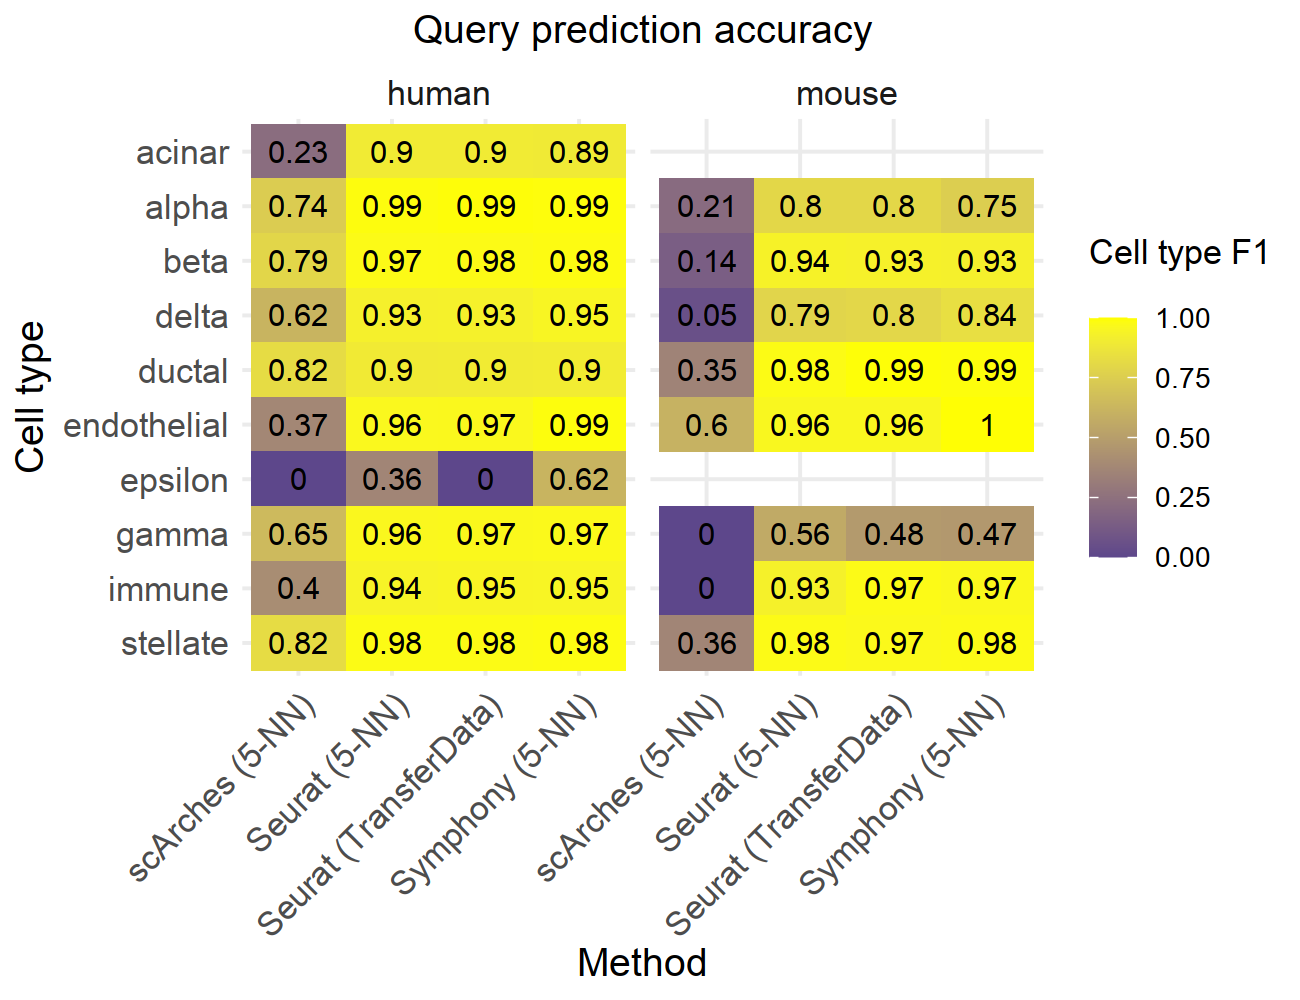

In [69]:
fig.size(5, 6.5)

pdf(paste0('figures/prediction_acc.pdf'), height=4, width=6, useDingbats=FALSE)

q = ggplot(long_agg_both_species, aes(y = forcats::fct_rev(cell_type), x = tool)) +
    geom_tile(aes(fill = F1)) + 
    geom_text(aes(label = round(F1, 2))) +
    scale_fill_gradient(low = "mediumpurple4", high = "yellow", limits = c(0, 1)) + 
    theme_minimal() +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=10)) + 
    labs(fill='Cell type F1\n') + 
    ylab('Cell type') + xlab('Method') + ggtitle('Query prediction accuracy') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=12),
        axis.text.y = element_text(hjust = 1, size=12),
        strip.text.x = element_text(size=12), legend.title=element_text(size=12),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=14)) +
    facet_wrap(~species)

print(q)
dev.off()
q

# Comparison of corresponding de novo integration algorithms

Harmony: Symphony/denovo_embedding.rds

Seurat: Seurat/de_novo_integration_embedding.rds

trVAE: scArches/trvae_pancreasdenovo_X.csv

## Process Harmony

In [70]:
method = 'Symphony'
results_dir = 'results'

all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = readRDS('Symphony/denovo_embedding.rds')

In [71]:
# Confirm correct order of rows
all(rownames(all_meta) == rownames(allZ))

[1] TRUE

In [72]:
symphony_denovo_results_meta = calculateResults(results_dir, method, allZ, all_meta)
saveRDS(symphony_denovo_results_meta, file.path(results_dir, 'Symphony_denovo_meta_results.rds'))

Predict query cell types

Calculate LISI

Run de novo UMAP on query and reference cells



In [73]:
symphony_denovo_query_lisis = calculateQueryLISI(allZ, all_meta)
saveRDS(symphony_denovo_query_lisis, file.path(results_dir, 'Symphony_denovo_query_lisis.rds'))

Calculate query LISI



In [74]:
p = drawDeNovoGraphs(file.path('figures'), method, allZ, symphony_denovo_results_meta)

Adding missing grouping variables: `cell_type`

Plot the points, color by batch

Plot the points, color by cell type



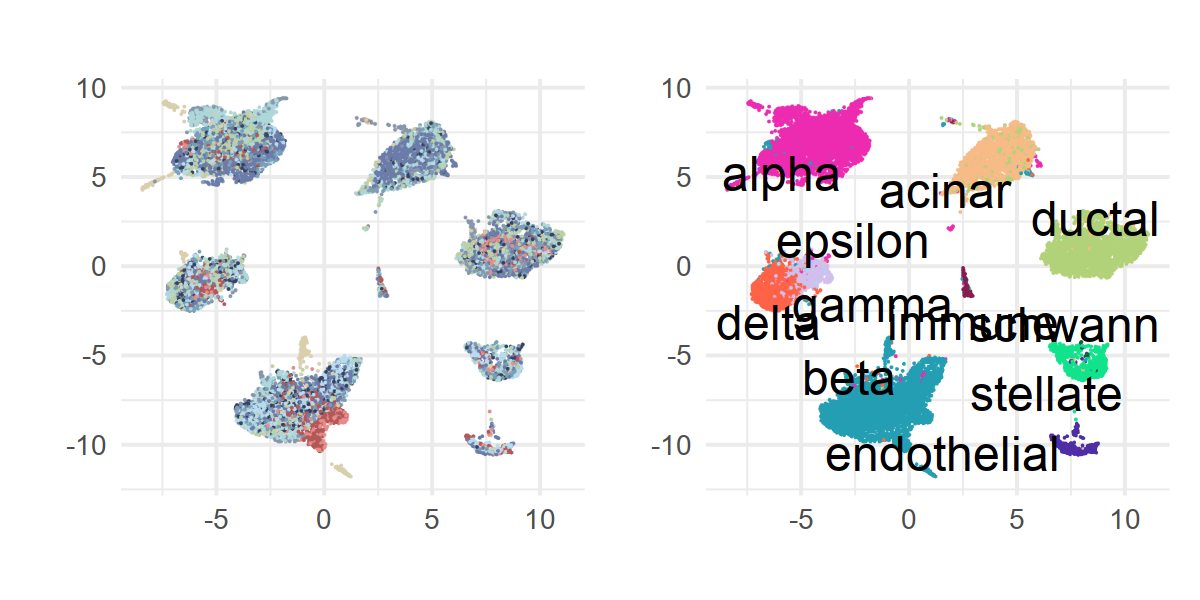

In [75]:
fig.size(3, 6)
print(p[[1]] | p[[2]])

## Process scArches / trVAE

In [76]:
method = 'scArches'

In [77]:
all_scArches = read.csv('scArches/trvae_pancreasdenovo_X.csv', header = FALSE)
meta_scArches = read.csv('scArches/trvae_pancreasdenovo_meta.csv')
rownames(all_scArches) = meta_scArches$cell_id

In [78]:
# Sort all such that the cell order matches
all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = all_scArches[order(match(rownames(all_scArches), rownames(all_meta))), ]
dim(allZ)
allZ %>% tail(2)

saveRDS(allZ, file.path(results_dir, 'scArches_denovo_allZ.rds'))

[1] 16342    10

V1        V2         V3         V4        
human4_lib3.final_cell_0700 0.2531402 -0.1320885  0.1912669 -0.7962078
human4_lib3.final_cell_0701 0.3614665 -0.0100663 -0.1233025 -0.4943306
                            V5         V6        V7           V8       
human4_lib3.final_cell_0700 -0.1467247 0.3782430 -0.063460611 0.1382342
human4_lib3.final_cell_0701 -0.2585419 0.4824339  0.004700614 0.1556826
                            V9         V10        
human4_lib3.final_cell_0700  0.3998443  0.01668683
human4_lib3.final_cell_0701 -0.1634603 -0.14759389

In [79]:
scArches_denovo_results_meta = calculateResults(results_dir, method, allZ, all_meta)
saveRDS(scArches_denovo_results_meta, file.path(results_dir, 'scArches_denovo_meta_results.rds'))

Predict query cell types

Calculate LISI

Run de novo UMAP on query and reference cells



In [80]:
scArches_denovo_query_lisis = calculateQueryLISI(allZ, all_meta)
saveRDS(scArches_denovo_query_lisis, file.path(results_dir, 'scArches_denovo_query_lisis.rds'))

Calculate query LISI



In [81]:
p = drawDeNovoGraphs(file.path('figures'), method, allZ, scArches_denovo_results_meta)

Adding missing grouping variables: `cell_type`

Plot the points, color by batch

Plot the points, color by cell type



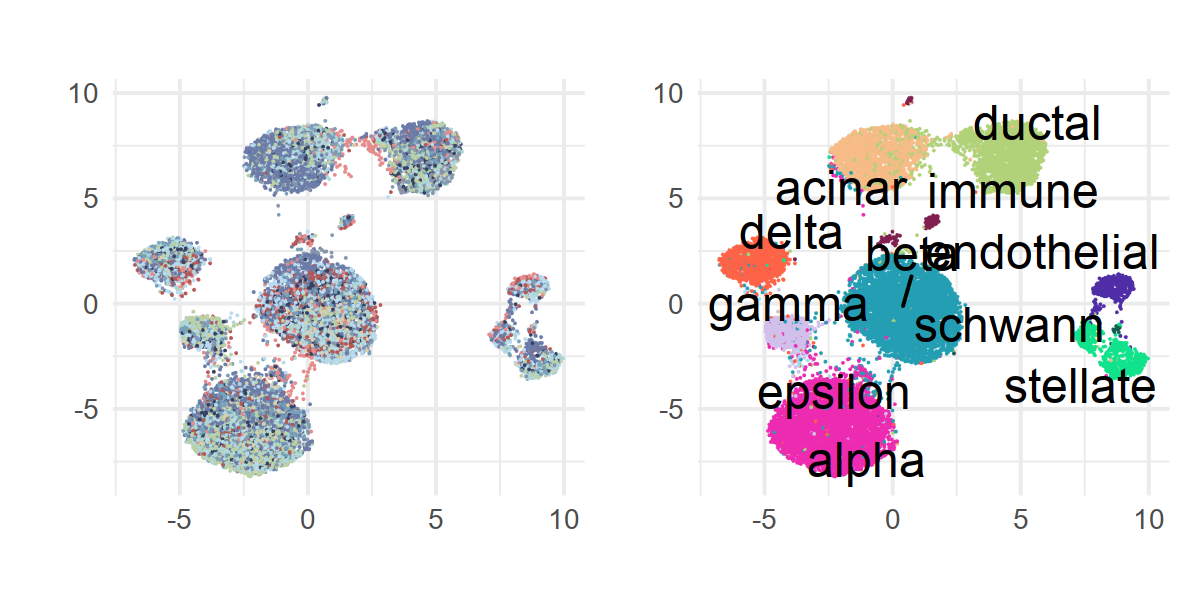

In [82]:
fig.size(3, 6)
print(p[[1]] | p[[2]])

## Process Seurat

In [83]:
method = 'Seurat'

In [84]:
all_Seurat = readRDS('Seurat/Seurat_de_novo_integration_embedding.rds')

In [85]:
# Sort all such that the cell order matches
all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = all_Seurat[order(match(rownames(all_Seurat), rownames(all_meta))), 1:20]
dim(allZ)
allZ %>% tail(2)

saveRDS(allZ, file.path(results_dir, 'Seurat_denovo_allZ.rds'))

[1] 16342    20

PC_1       PC_2     PC_3       PC_4     PC_5      
human4_lib3.final_cell_0700   9.514609 -1.09600 -0.1207821 -1.00990 -0.5413666
human4_lib3.final_cell_0701 -16.766772 10.54732 -2.6693365 12.37786 -7.9640075
                            PC_6     PC_7      PC_8       PC_9       PC_10     
human4_lib3.final_cell_0700 9.143476 3.3055312 -0.5557775  0.4036288 -0.1339219
human4_lib3.final_cell_0701 1.406569 0.1083046  1.2233009 -0.7447420 -0.7241504
                            PC_11     PC_12      PC_13      PC_14      
human4_lib3.final_cell_0700  1.168456  0.4868908 -0.8036893 0.008203387
human4_lib3.final_cell_0701 -5.459085 -0.7602131  1.2876721 1.157029042
                            PC_15     PC_16    PC_17      PC_18      PC_19     
human4_lib3.final_cell_0700  1.245508 2.591951  0.2420910 -2.8951340  1.1889194
human4_lib3.final_cell_0701 -2.693945 2.338682 -0.2570928  0.5427593 -0.1830459
                            PC_20    
human4_lib3.final_cell_0700 -1.972143
human4_lib3.final_cell_0701 -1.728004

In [86]:
seurat_denovo_results_meta = calculateResults(results_dir, method, allZ, all_meta)
saveRDS(seurat_denovo_results_meta, file.path(results_dir, 'Seurat_denovo_meta_results.rds'))

Predict query cell types

Calculate LISI

Run de novo UMAP on query and reference cells



In [87]:
seurat_denovo_query_lisis = calculateQueryLISI(allZ, all_meta)
saveRDS(seurat_denovo_query_lisis, file.path(results_dir, 'Seurat_denovo_query_lisis.rds'))

Calculate query LISI



In [88]:
p = drawDeNovoGraphs(file.path('figures'), method, allZ, seurat_denovo_results_meta)

Adding missing grouping variables: `cell_type`

Plot the points, color by batch

Plot the points, color by cell type



In [89]:
fig.size(3, 6)
print(p[[1]] | p[[2]])

## Plot ref/query LISI comparison

In [90]:
results_dir = 'results'

In [91]:
Symphony_res = readRDS(file.path(results_dir, 'Symphony_denovo_meta_results.rds'))
Symphony_res$Method = 'Harmony de novo'

Seurat_res = readRDS(file.path(results_dir, 'Seurat_denovo_meta_results.rds'))
Seurat_res$Method = 'Seurat de novo'

scArches_res = readRDS(file.path(results_dir, 'scArches_denovo_meta_results.rds'))
scArches_res$Method = 'trVAE de novo'

res_agg = rbind(Symphony_res, Seurat_res, scArches_res)
res_agg_query = res_agg[which(res_agg$ref_query == 'query'),]
dim(res_agg_query)

[1] 31365    17

In [92]:
res_agg_query$Method = factor(res_agg_query$Method, 
                              levels = c('trVAE de novo', 'Seurat de novo', 'Harmony de novo'))

png 
  2

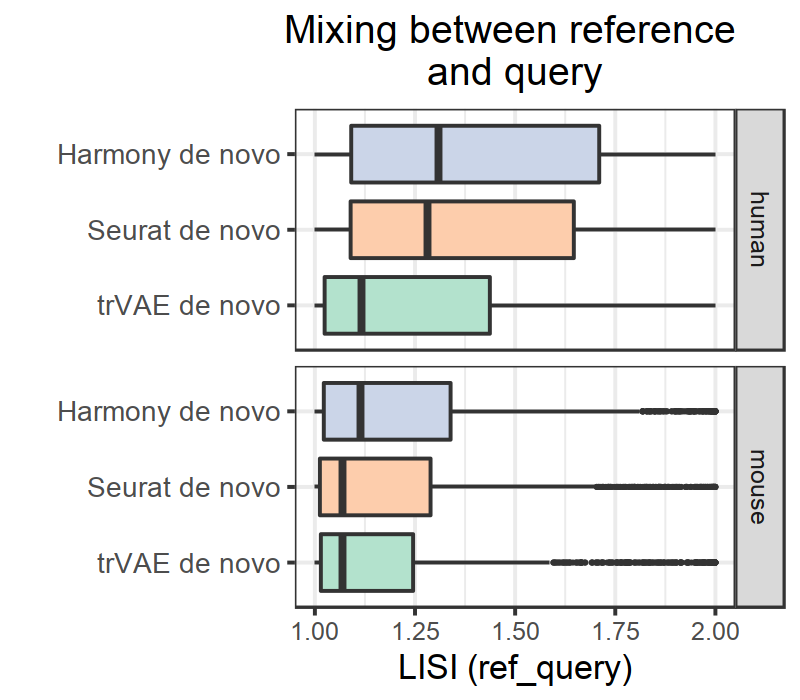

In [93]:
fig.size(3.5, 4)
pdf(paste0('figures/denovo_lisi_refquery.pdf'), height = 3.5, width = 4, useDingbats = FALSE)

l = ggplot(res_agg_query) +
      geom_boxplot(aes(x=ref_query_lisi, y=Method, fill=Method), outlier.size = 0.1) +
      #geom_density_ridges(aes(x = ref_query_lisi, y = Method, fill = Method, height =..ndensity..), scale = 1, alpha = 0.8, size = 0.4,
      #                quantile_lines=TRUE,
      #                quantile_fun=function(x,...)mean(x)) +
      theme_bw() +
      ylab('') + xlab('LISI (ref_query)') + ggtitle('Mixing between reference \nand query') +
      theme(axis.text.y = element_text(hjust = 1, size=10),
        strip.text.x = element_text(size=10),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12),
        legend.position = "none") +
      scale_fill_brewer(palette = 'Pastel2') +
      facet_wrap(~species, nrow = 2, strip.position = 'right')
                      
print(l)
dev.off()
l

### Print ref/query LISI stats

In [94]:
# 95% CI
#alpha = .05
for (tool in c('Harmony de novo','Seurat de novo','trVAE de novo')) {
    for (species in c('human', 'mouse')) {
        res = res_agg_query[which(res_agg_query$Method == tool & res_agg_query$species == species), ]
                print(paste0('Mean ref_query LISI and 95% CI for ', tool, ' and ', species, ':'))
        n = nrow(res)
        mu = mean(res$ref_query_lisi)
        me = qt(.975, n - 1)* sd(res$ref_query_lisi)/sqrt(n)
        print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
    }
}

[1] "Mean ref_query LISI and 95% CI for Harmony de novo and human:"
[1] "1.4 (1.4, 1.41)"
[1] "Mean ref_query LISI and 95% CI for Harmony de novo and mouse:"
[1] "1.23 (1.22, 1.25)"
[1] "Mean ref_query LISI and 95% CI for Seurat de novo and human:"
[1] "1.38 (1.37, 1.39)"
[1] "Mean ref_query LISI and 95% CI for Seurat de novo and mouse:"
[1] "1.2 (1.19, 1.21)"
[1] "Mean ref_query LISI and 95% CI for trVAE de novo and human:"
[1] "1.27 (1.26, 1.27)"
[1] "Mean ref_query LISI and 95% CI for trVAE de novo and mouse:"
[1] "1.19 (1.18, 1.2)"


## Plot query LISI comparison

In [95]:
symphony_denovo_query_lisis = readRDS(file.path(results_dir, 'Symphony_denovo_query_lisis.rds'))
seurat_denovo_query_lisis = readRDS(file.path(results_dir, 'Seurat_denovo_query_lisis.rds'))
scArches_denovo_query_lisis = readRDS(file.path(results_dir, 'scArches_denovo_query_lisis.rds'))

In [96]:
symphony_denovo_query_lisis$Method = 'Harmony de novo'
seurat_denovo_query_lisis$Method = 'Seurat de novo'
scArches_denovo_query_lisis$Method = 'trVAE de novo'

denovo_res_agg = rbind(symphony_denovo_query_lisis, seurat_denovo_query_lisis, scArches_denovo_query_lisis)
dim(denovo_res_agg)

[1] 31365    12

In [97]:
denovo_res_agg$Method = factor(denovo_res_agg$Method, 
                               levels = c('trVAE de novo', 'Seurat de novo', 'Harmony de novo'))

In [98]:
fig.size(3.5, 4)
pdf(paste0('figures/denovo_lisi_querydonor.pdf'), height=3.5, width=4, useDingbats=FALSE)

l = ggplot(denovo_res_agg) + # fill=name allow to automatically dedicate a color for each group
        geom_boxplot(aes(x=query_cells_donor_lisi, y=Method, fill=Method), outlier.size = 0.1) +
      #geom_density_ridges(aes(x=query_cells_donor_lisi, y=Method, fill=Method, height =..ndensity..), scale = 1, alpha = 0.8, size = 0.4,
      #                    quantile_lines=TRUE,
      #                    quantile_fun=function(x,...)mean(x)) +
        theme_bw() +
        ylab('') + xlab('LISI (query donors)') + ggtitle('Mixing between query donors') +
        theme(axis.text.y = element_text(hjust = 1, size=10),
        strip.text.y = element_text(size=10),
        plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12),
        legend.position = "none") +
        scale_fill_brewer(palette = 'Pastel2') +
        facet_wrap(~species, nrow = 2, strip.position = "right")

print(l)
dev.off()
l

png 
  2

### Print query LISI stats

In [99]:
denovo_res_agg %>% head(3)

cell_id                     dataset nGene donor 
mouse1_lib1.final_cell_0001 mouse1_lib1.final_cell_0001 inDrop  3205  mouse1
mouse1_lib1.final_cell_0002 mouse1_lib1.final_cell_0002 inDrop  3829  mouse1
mouse1_lib1.final_cell_0003 mouse1_lib1.final_cell_0003 inDrop  2582  mouse1
                            cell_type ref_query species batch 
mouse1_lib1.final_cell_0001 beta      query     mouse   mouse1
mouse1_lib1.final_cell_0002 ductal    query     mouse   mouse1
mouse1_lib1.final_cell_0003 delta     query     mouse   mouse1
                            query_cells_donor_lisi query_cells_species_lisi
mouse1_lib1.final_cell_0001 1.632048               1.006175                
mouse1_lib1.final_cell_0002 3.400053               1.849602                
mouse1_lib1.final_cell_0003 2.091049               1.059150                
                            query_cells_cell_type_lisi Method         
mouse1_lib1.final_cell_0001 1.000000                   Harmony de novo
mouse1_lib1.final_cell_0002 1.000000                   Harmony de novo
mouse1_lib1.final_cell_0003 1.007908                   Harmony de novo

In [100]:
# 95% CI, alpha = .05
for (tool in c('Harmony de novo', 'Seurat de novo', 'trVAE de novo')) {
    for (species in c('human', 'mouse')){
        res = denovo_res_agg[which(denovo_res_agg$Method == tool & denovo_res_agg$species == species), ]
        print(paste0('Mean query_donor LISI and 95% CI for ', tool, ' and ', species, ':'))
        n = nrow(res)
        mu = mean(res$query_cells_donor_lisi)
        me = qt(.975, n - 1)* sd(res$query_cells_donor_lisi)/sqrt(n)
        print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
    }
}

[1] "Mean query_donor LISI and 95% CI for Harmony de novo and human:"
[1] "2.55 (2.53, 2.57)"
[1] "Mean query_donor LISI and 95% CI for Harmony de novo and mouse:"
[1] "2.7 (2.66, 2.75)"
[1] "Mean query_donor LISI and 95% CI for Seurat de novo and human:"
[1] "2.96 (2.94, 2.98)"
[1] "Mean query_donor LISI and 95% CI for Seurat de novo and mouse:"
[1] "3.09 (3.05, 3.12)"
[1] "Mean query_donor LISI and 95% CI for trVAE de novo and human:"
[1] "2.52 (2.5, 2.54)"
[1] "Mean query_donor LISI and 95% CI for trVAE de novo and mouse:"
[1] "3.05 (3.02, 3.09)"


# Compare k-NN-corr within the query
Added June 25, 2021

calcknncorrWithinQueryBatch = function(Z_pca, Z_mapping, k, distance)

In [101]:
k = 500

## Symphony

In [102]:
query = readRDS('Symphony/query_baron.rds')

In [103]:
query$exp = Matrix(query$exp, sparse = TRUE)
query$meta_data$wiq_knn_corr = calcknncorrWithinQuery(query, var = 'species_donor',
                                            k = k, topn = 2000, d = 20, distance = 'euclidean')

Calculating k-NN correlation within query batch  mouse1

Calculating k-NN correlation within query batch  mouse2

Calculating k-NN correlation within query batch  human1

Calculating k-NN correlation within query batch  human2

Calculating k-NN correlation within query batch  human3

Calculating k-NN correlation within query batch  human4



In [104]:
Symphony_wiq_knn_corr = query$meta_data$wiq_knn_corr %>% as.data.frame()
Symphony_wiq_knn_corr$method = 'Symphony'
Symphony_wiq_knn_corr$species = query$meta_data$species
colnames(Symphony_wiq_knn_corr) = c('wiq_knn_corr', 'method', 'species')
Symphony_wiq_knn_corr %>% head()

## Calculate mean
for (species in c('human', 'mouse')) {
    res = Symphony_wiq_knn_corr[which(Symphony_wiq_knn_corr$species == species), ]
    print(paste0('Mean within-query k-NN-corr and 95% CI for ', species, ':'))
    n = nrow(res)
    mu = mean(res$wiq_knn_corr)
    me = qt(.975, n - 1) * sd(res$wiq_knn_corr)/sqrt(n)
    print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
}

wiq_knn_corr method   species
1 0.7929784    Symphony mouse  
2 0.8623646    Symphony mouse  
3 0.5880064    Symphony mouse  
4 0.7099133    Symphony mouse  
5 0.6386259    Symphony mouse  
6 0.7104119    Symphony mouse

[1] "Mean within-query k-NN-corr and 95% CI for human:"
[1] "0.59 (0.58, 0.59)"
[1] "Mean within-query k-NN-corr and 95% CI for mouse:"
[1] "0.55 (0.54, 0.57)"


## scArches

In [105]:
results_dir = 'results'

In [106]:
# Sort all such that the cell order matches
all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = readRDS(file.path(results_dir, 'scArches_mapping_allZ.rds'))

query_idx = which(all_meta$ref_query == 'query')
query_meta = all_meta[query_idx,]
query_Z = allZ[query_idx, ]

In [107]:
corrs = numeric(nrow(query_meta)) # initialize results
for (batch in unique(query_meta$donor)) { # for each batch
    message(paste0('Calculating k-NN correlation within query batch ', batch))
        
    batch_idx = which(query_meta$donor == batch)
    query_exp_batch = query$exp[, batch_idx]
        
    Z_pca = runPCAQueryAlone(query_exp_batch, topn = 2000, d = 10)
    Z_mapping = t(query_Z[batch_idx,])
        
    # Calculate correlation & save results
    corrs[batch_idx] = symphony:::calcknncorrWithinQueryBatch(
                            Z_pca, Z_mapping, k = k, distance = 'euclidean')
}
query_meta$wiq_knn_corr = corrs

Calculating k-NN correlation within query batch mouse1

Calculating k-NN correlation within query batch mouse2

Calculating k-NN correlation within query batch human1

Calculating k-NN correlation within query batch human2

Calculating k-NN correlation within query batch human3

Calculating k-NN correlation within query batch human4



In [108]:
scArches_wiq_knn_corr = query_meta$wiq_knn_corr %>% as.data.frame()
scArches_wiq_knn_corr$method = 'scArches'
scArches_wiq_knn_corr$species = query_meta$species
colnames(scArches_wiq_knn_corr) = c('wiq_knn_corr', 'method', 'species')
scArches_wiq_knn_corr %>% head()

## Calculate mean
for (species in c('human', 'mouse')) {
    res = scArches_wiq_knn_corr[which(scArches_wiq_knn_corr$species == species), ]
    print(paste0('Mean within-query k-NN-corr and 95% CI for ', species, ':'))
    n = nrow(res)
    mu = mean(res$wiq_knn_corr)
    me = qt(.975, n - 1) * sd(res$wiq_knn_corr)/sqrt(n)
    print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
}

wiq_knn_corr method   species
1 0.1835389    scArches mouse  
2 0.5233042    scArches mouse  
3 0.1495257    scArches mouse  
4 0.1710184    scArches mouse  
5 0.1480642    scArches mouse  
6 0.2186914    scArches mouse

[1] "Mean within-query k-NN-corr and 95% CI for human:"
[1] "0.19 (0.18, 0.19)"
[1] "Mean within-query k-NN-corr and 95% CI for mouse:"
[1] "0.13 (0.12, 0.13)"


In [109]:
mean(query_meta$wiq_knn_corr)

[1] 0.1748987

## Seurat

In [110]:
# Sort all such that the cell order matches
all_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')
allZ = readRDS(file.path(results_dir, 'Seurat_mapping_allZ.rds'))

query_idx = which(all_meta$ref_query == 'query')
query_meta = all_meta[query_idx,]
query_Z = allZ[query_idx, ]

In [111]:
corrs = numeric(nrow(query_meta)) # initialize results
for (batch in unique(query_meta$donor)) { # for each batch
    message(paste0('Calculating k-NN correlation within query batch ', batch))
        
    batch_idx = which(query_meta$donor == batch)
    query_exp_batch = query$exp[, batch_idx]
        
    Z_pca = runPCAQueryAlone(query_exp_batch, topn = 2000, d = 20)
    Z_mapping = t(query_Z[batch_idx,])
        
    # Calculate correlation & save results
    corrs[batch_idx] = symphony:::calcknncorrWithinQueryBatch(
                            Z_pca, Z_mapping, k = k, distance = 'euclidean')
}
query_meta$wiq_knn_corr = corrs

Calculating k-NN correlation within query batch mouse1

Calculating k-NN correlation within query batch mouse2

Calculating k-NN correlation within query batch human1

Calculating k-NN correlation within query batch human2

Calculating k-NN correlation within query batch human3

Calculating k-NN correlation within query batch human4



In [112]:
Seurat_wiq_knn_corr = query_meta$wiq_knn_corr %>% as.data.frame()
Seurat_wiq_knn_corr$method = 'Seurat'
Seurat_wiq_knn_corr$species = query_meta$species
colnames(Seurat_wiq_knn_corr) = c('wiq_knn_corr', 'method', 'species')
Seurat_wiq_knn_corr %>% head()

## Calculate mean
for (species in c('human', 'mouse')) {
    res = Seurat_wiq_knn_corr[which(Seurat_wiq_knn_corr$species == species), ]
    print(paste0('Mean within-query k-NN-corr and 95% CI for ', species, ':'))
    n = nrow(res)
    mu = mean(res$wiq_knn_corr)
    me = qt(.975, n - 1) * sd(res$wiq_knn_corr)/sqrt(n)
    print(paste0(round(mu, 2), ' (', round(mu - me, 2), ', ', round(mu + me, 2), ')'))
}

wiq_knn_corr method species
1 0.8111104    Seurat mouse  
2 0.8836605    Seurat mouse  
3 0.5863567    Seurat mouse  
4 0.7522325    Seurat mouse  
5 0.6543760    Seurat mouse  
6 0.7382239    Seurat mouse

[1] "Mean within-query k-NN-corr and 95% CI for human:"
[1] "0.6 (0.6, 0.61)"
[1] "Mean within-query k-NN-corr and 95% CI for mouse:"
[1] "0.57 (0.56, 0.58)"


In [113]:
mean(query_meta$wiq_knn_corr)

[1] 0.5957295

## Make plot of wiq-kNN-corr comparison

In [114]:
res_combined = rbind(Symphony_wiq_knn_corr, scArches_wiq_knn_corr, Seurat_wiq_knn_corr)

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.0387



png 
  2

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.0387



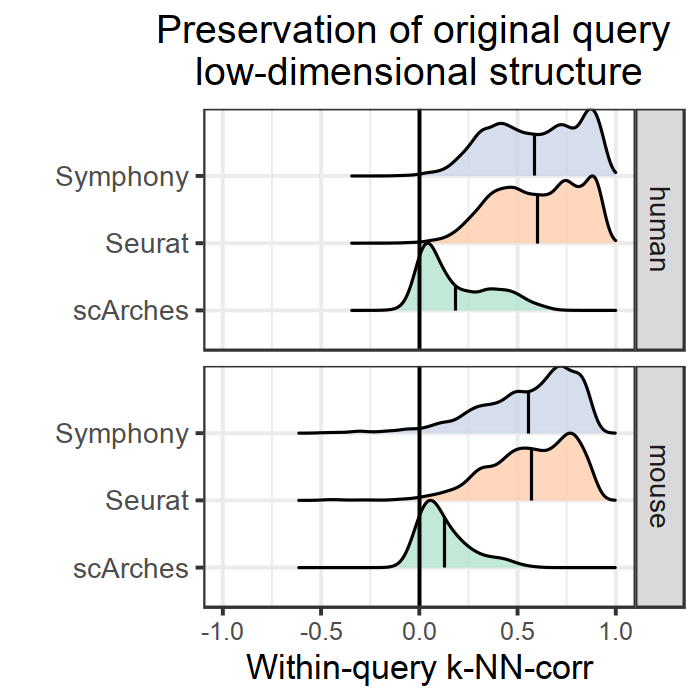

In [115]:
fig.size(3.5, 3.5)
pdf(paste0('figures/wiq_knn_corr_comparison.pdf'), height=3.5, width=3.5, useDingbats=FALSE)

library(ggridges)
l = ggplot(res_combined) +
          geom_density_ridges(aes(x=wiq_knn_corr, y=method, fill=method, height =..ndensity..), scale = 1, alpha = 0.8, size = 0.4,
                      quantile_lines=TRUE,
                      quantile_fun=function(x,...)mean(x)) +
          theme_bw() +
          ylab('') + xlab('Within-query k-NN-corr') + 
          ggtitle('Preservation of original query \nlow-dimensional structure') +
          theme(axis.text.y = element_text(hjust = 1, size=10),
                strip.text.y = element_text(size=10),
                plot.title = element_text(hjust = 0.5, size = 14), axis.title=element_text(size=12),
                legend.position = "none") +
          scale_fill_brewer(palette = 'Pastel2') + xlim(-1, 1) + geom_vline(xintercept = 0) +
          facet_wrap(~species, nrow=2, strip.position = 'right')                
print(l)
dev.off()
l

# All done!

In [116]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggridges_0.5.3          ggthemes_4.2.4          patchwork_1.1.1        
 [4] ggrepel_0.9.1           ggpubr_0.4.0            ggrastr_0.2.3          
 [7] RColorBrewer_1.1-2      pheatmap_1.0.12         biomaRt_2.46.3         
[10] symphony_1.0            Seurat